# Testing if Dan Foreman-Mackey's "money equation" works for my purposes.
Neglecting constant terms, his money equation is:

$$P(\{x_k\} | \gamma) = \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(q_k^{(n)}) q_k^{-\gamma}}{P(obs|q_k)} $$

## Status as of end of day on Thursday, August 12
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Next:
     - Add in observational uncertainties, and shift the measurements by appropriate amounts
     - Write code (subclass Fitters.Bayesian_LS) to fit the orbit to that information.
     - See what happens when I dial back the number of data points to a very small value.

## Status as of end of day on Sunday, August 23
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Observables have gaussian uncertainties
  - Code exists to fit the orbit.
    - It works for fitting large numbers of observations
    - It is slow though. I think that is because of the astropy quantity stuff, so I will have to remove a lot of that and try again.
  - Next:
     - Speed up fitting code
     - See what happens when I dial back the number of data points to a very small value.
     - Calculate orbit fits for a bunch of things, and see how well the a,e,q distributions are reproduced.
     
## Status as of end of day on Monday, August 31
   - TODO: Figure out why the simulated $\omega_k$ parameters don't give the write distribution parameters ($\theta$) when I apply the money equation
   
## Status as of end of day on Wednesday, Sep 2
   - Money equation works for well-sampled orbits.
   - Played with fitting mostly un-constrained orbits. MultiNest works much better, so I am using that. Starting to push through the sample now to see what the Money Equation says.
   - We sometimes get the wrong answer for q. I suspect that is just something that happens when the orbits are so poorly sampled. What does the method that Trent uses give you.
     - TODO: Plot rv1 vs rv2, fit a straight line. The slope gives you q.
     
## Things to check before finalizing decision:

  1. How much does the prior on the orbit fit affect the final parameters? I am mostly concerned with the mass-ratio distribution
  2. How much do completeness effects impact things?
  3. How do things like malmquist bias affect things? Theoretically, that should go into the observed rate density as a kind of 'reverse completeness correction', I think...
  4. I am implicitly converting from semi-major axis to period by going through the q samples and the primary mass, which I assume is known and I am giving no uncertainty. How much does having the wrong mass mess with things?

In [1]:
# Import stuff
import numpy as np
import scipy
import Mamajek_Table
from scipy.stats import truncnorm, lognorm, powerlaw, norm
import matplotlib.pyplot as plt
import ForwardModeling
import Fitters
import Orbit
import pandas as pd
from astropy import units as u, constants
import IMF_utils
import pandas as pd
import h5py
import logging
import Distributions
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# True parameters
true_mrd_alpha = 0.4    # Mass-ratio distribution
true_error = 0.03
N_sample = 400     # Number of stars in sample
N_mcmc = 1e6
true_mult_rate = 0.5   # Multiplicity rate
true_sep_mu = np.log(200)   # Separation mean
true_sep_sigma = np.log(10)   # Separation spread
true_ecc_alpha = 0.7   # eccentricity distribution parameter
true_min_mass = 2.0    # Minimum primary mass
true_max_mass = 6.0    # maximum primary mass

In [3]:
#Make a simulated sample.
np.random.seed(1)
a = np.random.lognormal(mean=true_sep_mu, sigma=true_sep_sigma, size=N_sample) * u.AU
e = ForwardModeling.truncated_expon(scale=true_ecc_alpha, Nsamp=N_sample)
q = ForwardModeling.truncated_expon(scale=true_mrd_alpha, Nsamp=N_sample)
prim_mass = IMF_utils.inverse_imf(np.random.uniform(size=N_sample), mmin=true_min_mass, mmax=true_max_mass) * u.M_sun
M0 = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
Omega = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
omega = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
sini = np.random.uniform(0, 1, size=N_sample)
i = np.arcsin(sini) * u.radian
Period = np.sqrt(4*np.pi**2*a**3 / (constants.G*(prim_mass + prim_mass*q))).to(u.year)

sample_parameters = pd.DataFrame(data=dict(a=a, e=e, q=q, M_prim=prim_mass, Period=Period.to(u.year),
                                           M0=M0.to(u.degree), big_omega=Omega.to(u.degree), 
                                           little_omega=omega.to(u.degree), i=i.to(u.degree)))
sample_parameters.head()

M0    M_prim         Period            a   big_omega         e  \
0  192.113667  3.539377  328522.194060  8421.226711  264.011794  0.112358   
1  266.179603  3.188666     148.711637    48.896028   69.270441  0.002982   
2  185.541730  3.809597     204.281445    59.273182  173.320523  0.154194   
3  143.980533  3.006643      34.558613    16.906798  289.294066  0.989219   
4  355.048842  3.587567   29048.327655  1467.025372  142.915756  0.509465   

           i  little_omega         q  
0  33.624786    245.903057  0.563023  
1  58.427273     23.623920  0.657362  
2  52.652179     65.062517  0.309584  
3  43.216476    249.950498  0.345505  
4  25.601356    270.812378  0.042716

In [4]:
# Make some RVs and imaging observations at random times throughout the period
def sample_orbit(star, N_rv, N_imag, rv1_err=None, rv2_err=None, pos_err=None, distance=100):
    """ Sample the binary orbit represented by the 'star' structure at N_rv random times for
    RV measurements, and N_imag random times for imaging measurements
    
    Parameters:
    ===========
    - rv1_err: Uncertainty on the primary star velocity measurements (in km/s or velocity Quantity)
    - rv2_err: Uncertainty on the secondary star velocity measurements (in km/s or velocity Quantity)
    - pos_err: On-sky positional error (in arcseconds or angle Quantity)
    - distance: The distance to the star (in parsecs or a distance Quantity)
    
    Returns:
    ========
    - Times of RV observations, primary and secondary rv measurements, 
      times of imaging observations, rho/theta measurements.
    """
    orbit = Orbit.OrbitCalculator(P=star['Period'], M0=star['M0'], a=star['a'], e=star['e'], 
                                  big_omega=star['big_omega'], little_omega=star['little_omega'],
                                  i=star['i'], q=star['q'], primary_mass=star['M_prim'])
    print('K1 = {}\nK2 = {}'.format(orbit.K1, orbit.K2))
    rv_times = np.random.uniform(0, star['Period'], size=N_rv)
    image_times = np.random.uniform(0, star['Period'], size=N_imag)
    rv_primary_measurements = orbit.get_rv(rv_times, component='primary')
    rv_secondary_measurements = -rv_primary_measurements * orbit.K2 / orbit.K1
    rho_measurements, theta_measurements = orbit.get_imaging_observables(image_times, distance=distance)
    
    # Add errors where requested
    if rv1_err is not None:
        rv_primary_measurements += np.random.normal(loc=0, scale=rv1_err, size=len(rv_times))
    if rv2_err is not None:
        rv_secondary_measurements += np.random.normal(loc=0, scale=rv2_err, size=len(rv_times))
    if pos_err is not None:
        x = rho_measurements*np.cos(theta_measurements) + np.random.normal(loc=0, scale=pos_err, size=len(image_times))
        y = rho_measurements*np.sin(theta_measurements) + np.random.normal(loc=0, scale=pos_err, size=len(image_times))
        rho_measurements = np.sqrt(x**2 + y**2)
        theta_measurements = np.arctan2(y, x)
    
    return rv_times, rv_primary_measurements, rv_secondary_measurements, image_times, rho_measurements, theta_measurements, orbit.K1, orbit.K2


K1 = 17.4960919963
K2 = 50.6392037356


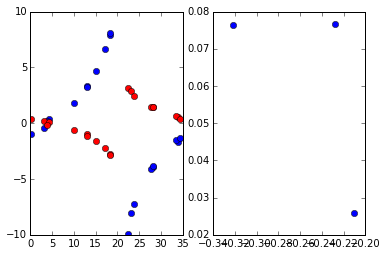

In [ ]:
reload(Orbit)
rv1_err = 0.1
rv2_err = 0.2
pos_err = 1e-2
t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(sample_parameters.ix[3], N_rv=20, N_imag=3,
                                                rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)
fig, axes = plt.subplots(ncols=2, nrows=1)
axes[0].plot(t_rv, rv2, 'bo')
axes[0].plot(t_rv, rv1, 'ro')
x = rho * np.sin(theta)
y = rho * np.cos(theta)
axes[1].plot(x, y, 'bo')

# Orbit fitting
Now that I can generate random data, let's write some code to fit the orbits and make sure that I get the right answer for a wide range of guesses. The likelihood function is separable into velocity and imaging observables, and the primary and secondary velocity components are themselves separable:

$$\log{L_{rv}} \propto \frac{-0.5(v-m(t))^2}{ \sigma_v^2} $$
$$\log{L_{image}} \propto \frac{-0.5((x-m(t))^2 + (y-m(t))^2)}{ \sigma_{pos}^2}  $$

In [100]:
#reload(Orbit)
fitter = Orbit.FullOrbitFitter(rv_times=t_rv, imaging_times=t_im, 
                           rv1_measurements=rv1, rv1_err=rv1_err,
                           rv2_measurements=rv2, rv2_err=rv2_err, 
                           rho_measurements=rho, theta_measurements=theta, pos_err=pos_err)

In [105]:
#reload(Orbit)
#reload(Fitters)
#fitter.fit(backend='multinest', basename='fitting_test/single-', overwrite=True)
fitter.fit(backend='emcee', guess=False, initial_pars=true_pars, nwalkers=400, n_burn=400, n_prod=200)

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF

Running burn-in
Running production

INFO:root:Done with production iteration 1 / 200
INFO:root:Done with production iteration 11 / 200
INFO:root:Done with production iteration 21 / 200
INFO:root:Done with production iteration 31 / 200
INFO:root:Done with production iteration 41 / 200
INFO:root:Done with production iteration 51 / 200
INFO:root:Done with production iteration 61 / 200
INFO:root:Done with production iteration 71 / 200
INFO:root:Done with production iteration 81 / 200
INFO:root:Done with production iteration 91 / 200
INFO:root:Done with production iteration 101 / 200
INFO:root:Done with production iteration 111 / 200
INFO:root:Done with production iteration 121 / 200
INFO:root:Done with production iteration 131 / 200
INFO:root:Done with production iteration 141 / 200
INFO:root:Done with production iteration 151 / 200
INFO:root:Done with production iteration 161 / 200
INFO:root:Done with production iteration 171 / 200
INFO:root:Done with production iteration 181 / 200
INFO:root:Done with production iteration 1

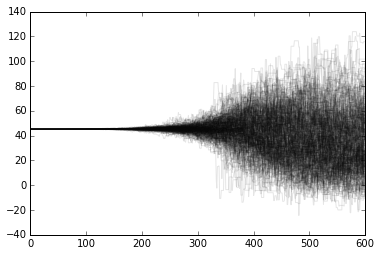

In [106]:
_ = plt.plot(fitter.sampler.chain[:, :, 1].T, 'k-', alpha=0.1)

In [22]:
n_burn = 400
fitter.make_emcee_samples(n_burn)

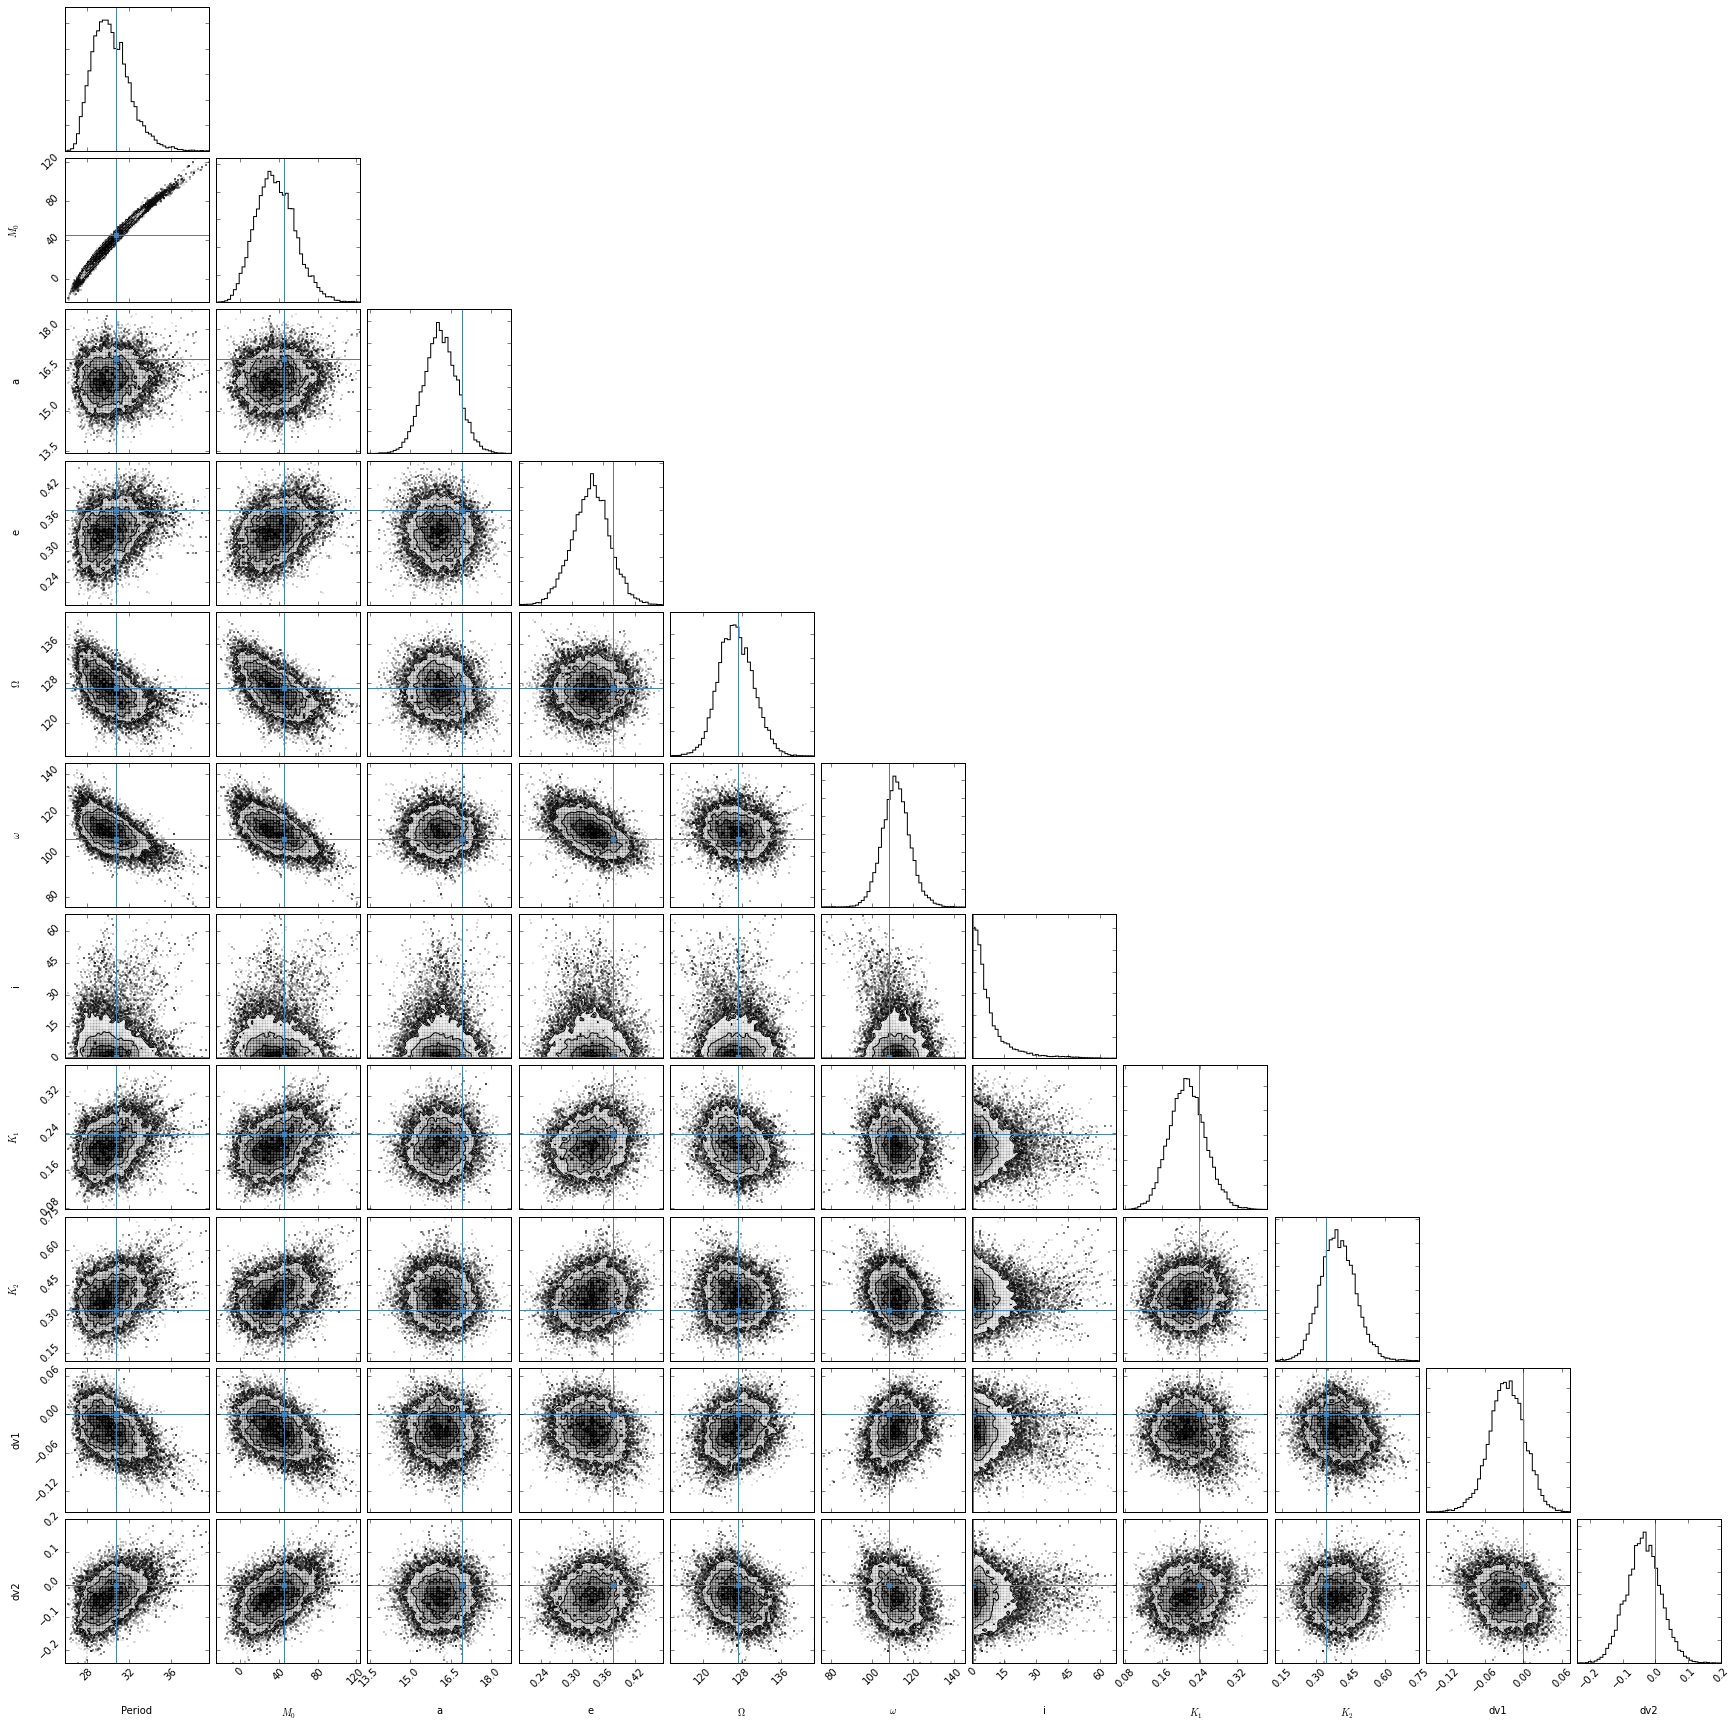

In [107]:
# Emcee results
fitter.triangle(truths=true_pars)

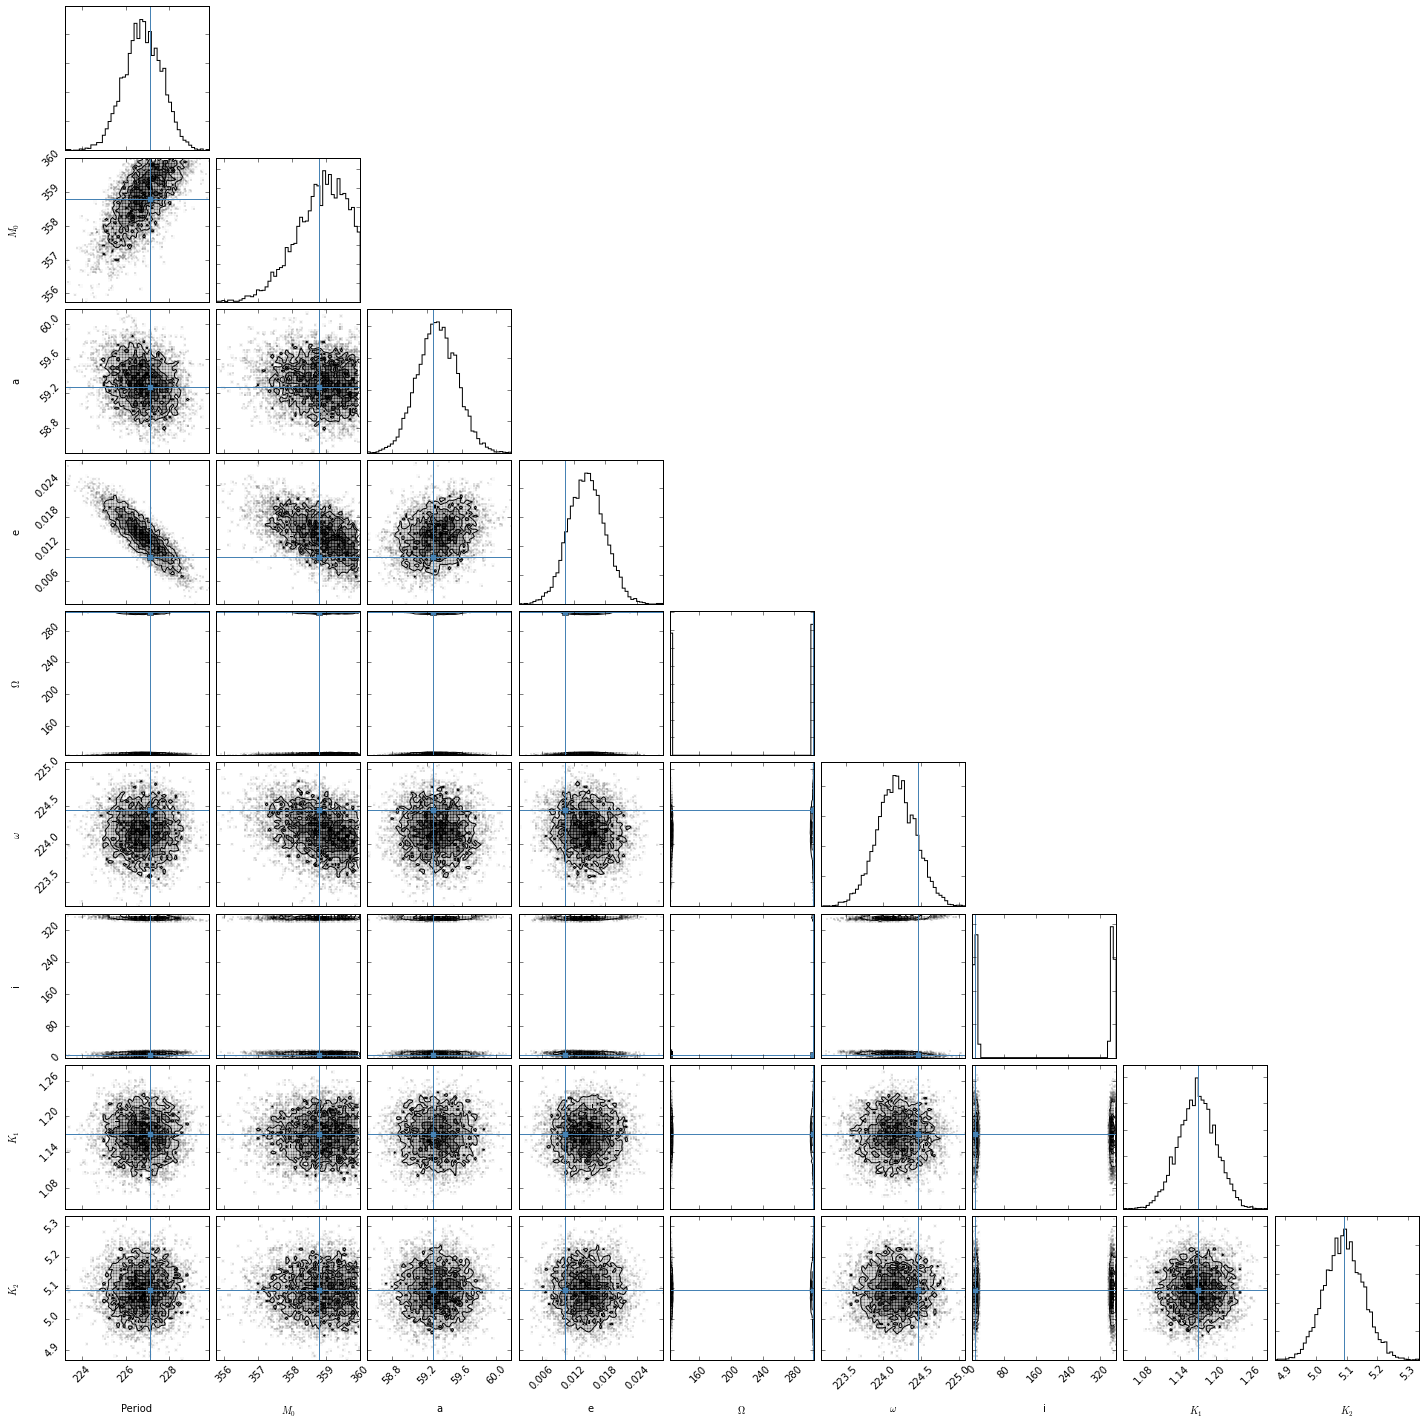

In [92]:
# multinest results
fitter.triangle(truths=true_pars)

# Fit several simulated stars
Save the MCMC samples in an HDF5 file to read in later and apply Dan's "Money Equation"

In [122]:

#reload(Orbit)
outfile = pd.HDFStore('Simulation_Data.h5', 'a')
for i, row in sample_parameters.iterrows():
    # Make some observations of this binary system
    t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(row, N_rv=20, N_imag=3,
                                                    rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)
        
    # Fit the orbit
    fitter = Orbit.FullOrbitFitter(rv_times=t_rv, imaging_times=t_im, 
                       rv1_measurements=rv1, rv1_err=rv1_err,
                       rv2_measurements=rv2, rv2_err=rv2_err, 
                       rho_measurements=rho, theta_measurements=theta, pos_err=pos_err)
    true_pars = [row['Period'], row['M0'], row['a'], row['e'], 
                 row['big_omega'], row['little_omega'], row['i'], 
                 K1, K2, 0.0, 0.0]
    print(i)
    fitter.fit(backend='emcee', guess=False, initial_pars=true_pars, nwalkers=400, n_burn=400, n_prod=300)
        
    # Save the MCMC samples
    outfile.put('production/ds{}'.format(i), fitter.samples, format='table', data_columns=True)
    outfile.flush()
    
outfile.close()

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF

K1 = 1.41423852541
K2 = 21.8625345097
100
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.08293748077
K2 = 6.67978582376

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


101
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.185547548628
K2 = 25.3575088071

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


102
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.85670088499
K2 = 4.28887396018

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


103
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0423578326139
K2 = 0.129240171076

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


104
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.92401968464
K2 = 8.76426048113

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


105
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.883597657365
K2 = 3.57425952978

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


106
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.82208926412
K2 = 6.35084052176

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


107
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.16787793046
K2 = 19.2660053603

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


108
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.49008690591
K2 = 1562.58978231

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


109
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 37.2760276522
K2 = 46.7393553199

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


110
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.809335219527
K2 = 1.63330148089

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


111
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.94606390501
K2 = 4.07605244803

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


112
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 27.2456595519
K2 = 29.585095579

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


113
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.633110860097
K2 = 90.5261493556

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


114
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 19.6786367368
K2 = 219.782912092

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


115
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.1111765844
K2 = 706.488909605

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


116
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 16.6218905618
K2 = 70.1046308448

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


117
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.22073748694
K2 = 1.55803015716

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


118
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.613092043193
K2 = 39.9174426825

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


119
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.22711730044
K2 = 21.6777321577

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


120
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.00834007379
K2 = 63.8041778565

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


121
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.44395116394
K2 = 2.21833506145

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


122
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.513907057146
K2 = 0.685269403896

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


123
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 26.1839090633
K2 = 4905.75837951

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


124
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.00706029794
K2 = 6.67078865236

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


125
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.125675808983
K2 = 1.36148038337

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


126
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.95243657946
K2 = 5.37110784928

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


127
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 22.1739864051
K2 = 24.4140288518

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


128
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.18667398258
K2 = 2.67585109362

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


129
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0629523603916
K2 = 0.0658357007683

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


130
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.62613434138
K2 = 15.4849359078

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


131
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 28.9398640713
K2 = 34.6329588382

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


132
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.145676320359
K2 = 0.584226337601

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


133
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.168111934498
K2 = 1.86772937038

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


134
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 11.5360545465
K2 = 12.770471707

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


135
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.87955170798
K2 = 3.53777383382

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


136
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.98823489468
K2 = 571.1652816

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


137
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.67415074083
K2 = 5.89047847074

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


138
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.11198896528
K2 = 7.42670215305

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


139
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 8.30092873291
K2 = 19.1847092727

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


140
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.0211515719
K2 = 3.39659003922

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


141
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.53868482781
K2 = 15.1598116743

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


142
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.900753593544
K2 = 2.10748405235

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


143
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.21301291039
K2 = 3.11453269585

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


144
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.04061618608
K2 = 392.750504

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


145
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.25844631471
K2 = 37.4764104838

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


146
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.15987315417
K2 = 4.20500346717

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


147
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.02791429131
K2 = 6.74669594046

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


148
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.54110397072
K2 = 4.42196722845

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


149
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.44103942748
K2 = 14.6918005575

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


150
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 41.2210177704
K2 = 315.178013646

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


151
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.841927376571
K2 = 1.05643913247

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


152
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.273368517233
K2 = 1.15292476689

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


153
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0287325039796
K2 = 2.77474909682

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


154
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.80532803153
K2 = 2.16395106352

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


155
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.37531200616
K2 = 33.7704847717

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


156
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.57646581787
K2 = 9.03982020872

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


157
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.66580939605
K2 = 5.75441196459

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


158
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 56.3880910454
K2 = 187.216024019

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


159
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 12.027869111
K2 = 28.3003063522

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


160
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 8.14522937599
K2 = 23.6692796318

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


161
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.42315424747
K2 = 14.0655045201

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


162
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.88310468136
K2 = 8.93591160058

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


163
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.55944093496
K2 = 12.8488001825

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


164
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.09669999037
K2 = 2.57621875228

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


165
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.29200663338
K2 = 0.750251529551

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


166
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.79979970264
K2 = 139.513438203

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


167
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.356073082798
K2 = 4.21527261586

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


168
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 14.9321277678
K2 = 35.3779494377

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


169
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.31002990184
K2 = 79.172153844

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


170
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.693373603231
K2 = 20.4121507399

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


171
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0337020318777
K2 = 0.701151393909

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


172
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.42924098821
K2 = 5.86602627582

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


173
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.77244555168
K2 = 4.12754007509

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


174
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.203511803862
K2 = 0.216497561111

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


175
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.512977164934
K2 = 3.01283900227

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


176
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.85916761366
K2 = 16.2673358492

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


177
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.13255287496
K2 = 7.35989270557

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


178
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.14562709243
K2 = 11.5474124969

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


179
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.91794519063
K2 = 769.814951114

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


180
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.70759618797
K2 = 2.75619762745

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


181
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.08737586808
K2 = 5.55887177902

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


182
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.995534543382
K2 = 2.82640490404

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


183
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.844324690357
K2 = 13.1496537646

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


184
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.02403681677
K2 = 6.45765545694

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


185
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.99615379991
K2 = 7235.09305569

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


186
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.781744913818
K2 = 5.00468845265

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


187
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.598604894228
K2 = 0.690843349835

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


188
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.20167454573
K2 = 2.90874695671

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


189
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.97586058932
K2 = 2.56439567292

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


190
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.41377914371
K2 = 7.89530528031

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


191
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.357658933956
K2 = 0.495268218563

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


192
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.90104453749
K2 = 2.35475708458

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


193
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.96212829846
K2 = 6.39374521312

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


194
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 11.1769447586
K2 = 367.632693154

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


195
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.594474015322
K2 = 1.02471470062

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


196
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.46643168611
K2 = 9.67706990947

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


197
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.646244410699
K2 = 20.2099451364

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


198
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.00164328859
K2 = 2.41458658711

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


199
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.31579121872
K2 = 1350.07584629

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


200
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.252471057929
K2 = 3.68555422871

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


201
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 19.7570030615
K2 = 29.3697847662

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


202
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.315992952985
K2 = 495.711456379

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


203
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.37363011284
K2 = 17.3320542079

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


204
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 41.7041330695
K2 = 25330.0675108

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


205
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 81.1637001075
K2 = 81.5050566327

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


206
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 9.97378473565
K2 = 24.5820295296

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


207
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 10.6279835203
K2 = 82.0494889426

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


208
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.027561742795
K2 = 0.0311640000539

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


209
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 8.30853741424
K2 = 25.7636567691

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


210
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.38577744948
K2 = 23.751145567

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


211
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0365728383305
K2 = 0.0886518864665

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


212
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 9.73002277151
K2 = 89.4808339678

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


213
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 19.401061059
K2 = 140.165742885

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


214
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.28535192246
K2 = 6.69046406878

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


215
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0062155132839
K2 = 0.0650378516267

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


216
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.735655445378
K2 = 1.80014876913

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


217
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.727057906175
K2 = 1.3305983185

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


218
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.957926445767
K2 = 76.9677513525

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


219
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.2559706752
K2 = 2.36904126909

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


220
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.28069269595
K2 = 5.26307238429

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


221
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.33479054576
K2 = 1.91150251055

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


222
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.88556097195
K2 = 9.47191228464

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


223
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 42.5167715747
K2 = 2858.85503993

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


224
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.110999793933
K2 = 0.375001795682

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


225
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.910848499369
K2 = 3.50282959965

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


226
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 10.9202612453
K2 = 21.1564104632

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


227
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.5510155371
K2 = 13.5009922533

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


228
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.64099589296
K2 = 10.117639472

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


229
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.2059060137
K2 = 9.8604985974

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


230
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.09072086815
K2 = 5.63876842458

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


231
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.02960245223
K2 = 2.2925501248

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


232
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.254539251046
K2 = 5.94591748647

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


233
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.2673414189
K2 = 1.99882045482

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


234
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 21.3498234124
K2 = 32.2304793346

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


235
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 14.2199562472
K2 = 16.8216433492

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


236
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 11.0002698642
K2 = 124.001258534

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


237
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 23.3898089985
K2 = 420.454391225

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


238
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.161586494495
K2 = 0.772550697535

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


239
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.98449822339
K2 = 53.1767230446

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


240
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 9.35223433713
K2 = 13.1390081618

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


241
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.57230998096
K2 = 3.54935961093

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


242
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.27068460799
K2 = 2.00761352687

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


243
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.45608691787
K2 = 26.5947768918

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


244
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.58921284127
K2 = 74.4576700627

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


245
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.00187763833
K2 = 36.8212006904

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


246
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.23633221296
K2 = 32.2075899503

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


247
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.355965290976
K2 = 5.48242855114

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


248
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.432415945679
K2 = 0.601016833543

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


249
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 9.54639940067
K2 = 22.388590836

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


250
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.04287442817
K2 = 5.66345222042

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


251
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 134.203198857
K2 = 439.000447113

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


252
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.349671886444
K2 = 20.0183876502

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


253
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.30706886258
K2 = 25.765685287

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


254
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 9.16458613358
K2 = 33.2404270042

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


255
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0676585901263
K2 = 1.00089496762

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


256
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.440438442421
K2 = 199.676268539

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


257
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.620520523447
K2 = 1.04990217648

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


258
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.31443027884
K2 = 10.7941210444

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


259
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.456972810182
K2 = 2.89406564516

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


260
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 26.854879658
K2 = 35.6631559681

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


261
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.09209973896
K2 = 4.48512725113

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


262
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.3696833381
K2 = 1.74524340595

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


263
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.06339040797
K2 = 4.15496193364

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


264
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.257005206413
K2 = 0.63523918397

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


265
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.27986029559
K2 = 18.5987811217

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


266
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.62255504445
K2 = 21.9917732143

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


267
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.45732293913
K2 = 5.36819414799

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


268
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.27201210642
K2 = 52.6222189942

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


269
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.24816436758
K2 = 1.57139990858

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


270
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.31261529685
K2 = 1.53957382858

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


271
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.777052701751
K2 = 4.93478526404

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


272
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.277896789908
K2 = 0.524529860633

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


273
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.17991663377
K2 = 8.57055029453

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


274
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.811793435763
K2 = 59.9306359025

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


275
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 40.0285130466
K2 = 49.6661838065

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


276
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.669144233965
K2 = 10.5780709395

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


277
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.20107895226
K2 = 1.575445897

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


278
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.25429667964
K2 = 2.46260629611

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


279
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.98559034752
K2 = 29.4717431428

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


280
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.24155520677
K2 = 121.908460048

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


281
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.30952217524
K2 = 7.04779113307

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


282
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.23275787273
K2 = 5.5737131455

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


283
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.87229360411
K2 = 2.59649150015

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


284
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.79948318757
K2 = 3.90486133984

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


285
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.79891562786
K2 = 4.09262147862

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


286
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.823642190043
K2 = 1.98493465461

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


287
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.17246381982
K2 = 62.119622245

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


288
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.75612219163
K2 = 23.5582698571

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


289
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.4468947985
K2 = 15.0122074674

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


290
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 12.337423038
K2 = 12.5048492363

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


291
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.628467181875
K2 = 3.14914703565

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


292
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.65226671135
K2 = 6.73398761077

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


293
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.74865923633
K2 = 8.2056884813

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


294
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.1824104813
K2 = 59.6622112099

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


295
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.697024446786
K2 = 52.7555621133

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


296
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.286496147041
K2 = 1.50032312337

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


297
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 12.7000711721
K2 = 415.116763377

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


298
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.02775008664
K2 = 2.19354624036

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


299
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.245352750882
K2 = 1.06724431263

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


300
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.78444633125
K2 = 2.82712092553

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


301
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.79765065599
K2 = 4.28625465678

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


302
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.14790250636
K2 = 27.3389720302

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


303
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 6.91264433575
K2 = 32.5235668509

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


304
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.10931818663
K2 = 0.396534733433

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


305
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.36310918
K2 = 8.8145941093

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


306
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.75822342914
K2 = 4.16998515004

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


307
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.693508781783
K2 = 2.29905246112

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


308
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 12.0095126511
K2 = 50.9863996506

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


309
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.630914140383
K2 = 5.88124030322

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


310
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.91868979841
K2 = 9.25287613585

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


311
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.411150304344
K2 = 233.21212589

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


312
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.177552909705
K2 = 0.246593563505

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


313
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0558433625787
K2 = 0.901378766068

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


314
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0545199293756
K2 = 0.102236265059

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


315
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.592977255345
K2 = 3.3283626548

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


316
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.02705446784
K2 = 5.25078214406

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


317
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.92509681208
K2 = 195.37206632

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


318
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.66788582634
K2 = 59.6774959834

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


319
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.96077056008
K2 = 6.03049134724

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


320
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 7.68864655641
K2 = 18.875480729

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


321
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.58449939689
K2 = 11.204290481

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


322
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.47616388646
K2 = 387488.370239

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


323
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.318271270637
K2 = 3.75132076595

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


324
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.813599335531
K2 = 20.2357116885

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


325
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.6150194311
K2 = 37.1623338985

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


326
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.19598994953
K2 = 2.63546025749

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


327
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 8.15811399933
K2 = 10.2287159063

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


328
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.12842385747
K2 = 3.85415188105

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


329
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.62285701611
K2 = 9.21535658264

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


330
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.00361198863
K2 = 1.3770117083

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


331
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.76864518046
K2 = 12.1330273505

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


332
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.461408036
K2 = 18.6968297674

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


333
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.568801621396
K2 = 4.87327202999

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


334
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 13.0335846554
K2 = 14.8489986453

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


335
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 41.4517660154
K2 = 201.702632128

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


336
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 48.4679813346
K2 = 157.598346386

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


337
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 66.0379380959
K2 = 646.382998899

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


338
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 173.499903183
K2 = 212.693639659

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


339
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.3201479121
K2 = 16.418308481

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


340
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.616331969409
K2 = 4.64680716911

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


341
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 10.2251606689
K2 = 17.7775198527

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


342
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.31568995352
K2 = 36.597479076

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


343
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.25001312854
K2 = 149.304517363

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


344
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.33973849236
K2 = 5.83789637029

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


345
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.12056800549
K2 = 3.47028456552

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


346
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.27800911724
K2 = 7.88651500732

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


347
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.99551154245
K2 = 42.2556679717

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


348
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 14.673015019
K2 = 32.2665252331

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


349
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.47347271224
K2 = 3.1134217837

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


350
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.94469568089
K2 = 12.4933625597

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


351
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.65963703412
K2 = 237.73714175

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


352
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.83101329635
K2 = 7.20825323802

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


353
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.52335978319
K2 = 20.1530926804

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


354
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.114568038268
K2 = 0.179485131627

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


355
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.72936374136
K2 = 26.8115974395

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


356
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.51363977015
K2 = 10.8327914705

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


357
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.231768973673
K2 = 0.950543885704

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


358
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 9.5767805981
K2 = 47.5981337023

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


359
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.919194899104
K2 = 28.7543435759

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


360
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.0494276412886
K2 = 0.517840746279

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


361
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 21.6621639985
K2 = 1478.65573231

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


362
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.00446462357
K2 = 21.9972276678

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


363
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.767245767692
K2 = 1.26245532514

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


364
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.152669997669
K2 = 0.343249567537

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


365
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 3.01493207884
K2 = 5.84188150662

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


366
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 63.6118911482
K2 = 183879.083459

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


367
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.75246867463
K2 = 5.25537716488

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


368
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.05754244104
K2 = 6.46361565581

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


369
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.43281498951
K2 = 16.4863204847

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


370
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.39867776371
K2 = 43.8534071455

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


371
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.11337131044
K2 = 18.5390352503

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


372
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 13.6347775094
K2 = 18.0795532818

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


373
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.991062709131
K2 = 1.02050246288

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


374
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.36131907166
K2 = 5.06890045728

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


375
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.183724926594
K2 = 1.07032444065

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


376
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 10.6532202896
K2 = 16.1107167064

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


377
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 35.4275557061
K2 = 96.9953821186

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


378
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.20346361984
K2 = 1.68742204013

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


379
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.781050232953
K2 = 2.62026464979

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


380
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.9896604618
K2 = 12.0238640796

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


381
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 46.1477388434
K2 = 68.7517272438

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


382
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 4.94174870051
K2 = 228.481430652

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


383
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.558673971377
K2 = 1.57467779156

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


384
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.19246511196
K2 = 11.7083892162

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


385
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 5.70270146829
K2 = 13.2023563133

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


386
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 30.5121477083
K2 = 32.728354458

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


387
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.188624503406
K2 = 0.895234266961

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


388
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.48459481128
K2 = 11.7846780899

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


389
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 182.069779008
K2 = 269.32457312

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


390
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.604150076227
K2 = 1.25446149519

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


391
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.84852156006
K2 = 8.73394809133

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


392
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 2.02837667334
K2 = 3.77424825484

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


393
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 8.36962568234
K2 = 37.908291422

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


394
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.973297922422
K2 = 27.0237511163

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


395
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 24.9188373215
K2 = 94.074725767

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


396
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.81150981666
K2 = 11.2431568321

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


397
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 1.42939282988
K2 = 18.1061985558

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


398
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1


K1 = 0.227557713517
K2 = 0.258771217139

INFO:root:Done with burn-in iteration 1 / 400
INFO:root:Done with burn-in iteration 11 / 400
INFO:root:Done with burn-in iteration 21 / 400
INFO:root:Done with burn-in iteration 31 / 400
INFO:root:Done with burn-in iteration 41 / 400
INFO:root:Done with burn-in iteration 51 / 400
INFO:root:Done with burn-in iteration 61 / 400
INFO:root:Done with burn-in iteration 71 / 400
INFO:root:Done with burn-in iteration 81 / 400
INFO:root:Done with burn-in iteration 91 / 400
INFO:root:Done with burn-in iteration 101 / 400
INFO:root:Done with burn-in iteration 111 / 400
INFO:root:Done with burn-in iteration 121 / 400
INFO:root:Done with burn-in iteration 131 / 400
INFO:root:Done with burn-in iteration 141 / 400
INFO:root:Done with burn-in iteration 151 / 400
INFO:root:Done with burn-in iteration 161 / 400
INFO:root:Done with burn-in iteration 171 / 400
INFO:root:Done with burn-in iteration 181 / 400
INFO:root:Done with burn-in iteration 191 / 400
INFO:root:Done with burn-in iteration 201 / 400
INF


399
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1

# Apply the Money Equation:
Here it is as written in the paper

$$P(\{x_k\} | \theta) = p(\{x_k\} | \alpha) \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(\omega_k^{(n)}) \Gamma_{\theta}(\omega_k^{(n)})}{P(\omega_k^{(n)} | \alpha)} $$



The $x_k$ are the individual rv/imaging measurements, the $\omega_k^{(n)}$ are the orbital parameters for star k and MCMC chain n, and $\alpha$ encode the priors I used for finding the orbital parameters from the rv/imaging data. $Q_c$ is the completeness fraction for that set of parameters, and is unity in these simulations. I used uniform priors for all parameters, so $p(\{x_k\} | \alpha) = P(\omega_k^{(n)} | \alpha) = 1$

The $\theta$ I am trying to fit for is the set of parameters describing the semimajor axis, eccentricity, and mass-ratio distributions of the binary stars:

$$\Gamma(a, e, q | \gamma, \mu, \sigma, \eta) = \Gamma(q|\gamma) \Gamma(a|\mu, \sigma) \Gamma(e|\eta) $$

where

$$\Gamma(q|\gamma) = (1+\gamma)q^{\gamma} $$
$$\Gamma(a|\mu, \sigma) = \frac{1}{a\sigma\sqrt{2\pi}} e^{-0.5(\ln{a} - \mu)^2 / \sigma^2} $$
$$\Gamma(e|\eta) = (1+\eta)e^{\eta} $$

The full equation is then:

$$P(\{x_k\} | \gamma, \mu, \sigma, \eta) = \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} (1+\gamma)q_{k,n}^{\gamma} (1+\eta)e_{k,n}^{\eta} \frac{1}{a_{k,n}\sigma\sqrt{2\pi}} e^{-0.5(\ln{a_{k,n}} - \mu)^2 / \sigma^2} $$

That whole thing is just the likelihood function for the parameters we care about. We will have to find the maximum likelihood (another MCMC fit!) to get the best-fit parameters back. For that we need the log-likelihood:

$$ \ln{P(\{x_k\} | \gamma, \mu, \sigma, \eta)} = \sum_{k=1}^K \ln{ \sum_{n=1}^{N_k} \Gamma(q, a, e | \gamma, \mu, \sigma, \eta) } $$

Where I reverted back to using $\Gamma$ instead of the fully fleshed-out version as in the likelihood function.

In [3]:
infile = pd.HDFStore('Simulation_Data.h5', 'a')

In [4]:
# The production 'folder' in the hdf5 file has the full chains. We only want a few of the columns.
# Let's also thin the MCMC chains by a factor of 10 to speed things up
thin_factor = 10
for i in range(N_sample):
    if i % 25 == 0:
        logging.info(i)
    full_df = pd.read_hdf(infile, 'production/ds{}'.format(i))
    full_df['q'] = full_df['$K_1$'] / full_df['$K_2$']
    infile['thinned/ds{}'.format(i)] = full_df[['q', 'a', 'e']].sample(full_df.shape[0]/thin_factor)
    infile.flush()


INFO:root:0
INFO:root:25
INFO:root:50
INFO:root:75
INFO:root:100
INFO:root:125
INFO:root:150
INFO:root:175
INFO:root:200
INFO:root:225
INFO:root:250
INFO:root:275
INFO:root:300
INFO:root:325
INFO:root:350
INFO:root:375


In [18]:
# Additionally save the arrays as plain numpy arrays (even faster)
with h5py.File('Simulation_Data.h5', 'a') as f:
    for i in range(N_sample):
        df = infile['thinned/ds{}'.format(i)]
        f.create_dataset('plain/ds{}'.format(i), data=df.values)
        f.flush()
    

In [182]:
# Just make simulated datasets with the correct parameters
q_sigma = 0.01
e_sigma = 0.01
a_sigma = 1.0
with h5py.File('Simulation_Data.h5', 'a') as f:
    for i in range(N_sample):
        true_q, true_a, true_e = sample_parameters.ix[i][['q', 'a', 'e']]
        q = scipy.stats.truncnorm.rvs(a=-true_q/q_sigma, b=(1-true_q)/q_sigma, loc=true_q, scale=q_sigma, size=1000)
        a = scipy.stats.truncnorm.rvs(a=-true_a/a_sigma, b=np.inf, loc=true_a, scale=a_sigma, size=1000)
        e = scipy.stats.truncnorm.rvs(a=-true_e/e_sigma, b=(1-true_e)/e_sigma, loc=true_e, scale=e_sigma, size=1000)
        #print(true_q, true_a, true_e)
        data = np.array((q, a, e)).T
        #print(np.median(data, axis=0))
        f.create_dataset('simulated3/ds{}'.format(i), data=data)
        f.flush()

# Try out the fitter on the simulated data.



In [297]:
reload(Distributions)
with h5py.File('Simulation_Data.h5', 'r') as f:
    samples = np.array([f['plain/ds{}'.format(i)].value for i in range(N_sample)])
fitter = Distributions.DistributionFitter(samples)
fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, 703.88310367223335]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, 703.88310517555124]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, 703.88310360693754]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, 703.88310430250704]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, 703.88309954824513]
Distributions.py:44: RuntimeWarning: divide by zero encountered in log
  return np.log(Gamma.mean(axis=1)).sum()
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999999417893837, 5.0000000582106168, 4.9999999418010255, 0.5000000058094195, 703.88309635312635]
INFO:root:[0.50000000417893842, 5.0000000582106168, 4.9999999418010255, 0.5000000058094195, 703.88309785644424]
INFO:root:[0.49999999417893837, 5.0000000682106167, 4.9999999418010255, 0.5000000058094195, 703.8830962878

array([ 0.37929035,  5.41539551,  2.24739711,  0.68831739])

## It works!
So this method shows promise if we have the full orbit fits. Unfortunately, we don't. What we have is 1-4 rv epochs, and 0-1 imaging epochs. In that case, the posterior samples for the orbit parameters ($\omega_k = q,a,e$) will be dominated by the priors of the fit. We can use priors from previous studies, but I want to check if the priors cause the distribution fitter to give the wrong answer. Thus, I will use the same functions for the priors with the following parameters (the true parameters I used in the simulation are shown in parentheses):

$$\gamma = 0.7 (0.4) \\
  \mu = 7.0 (5.3) \\
  \sigma = 3.0 (2.3) \\
  \eta = 0.3 (0.7) $$
  
So the first thing to test is how many MCMC samples it takes to converge to the posterior distribution when we only have a few measurements. I will try with 2 RV samples and no imaging (the most common case for my survey).

In [75]:
#reload(Orbit)
rv1_err = 0.1
rv2_err = 0.2
pos_err = 1e-2
idx = 9
print sample_parameters.ix[idx]
t_rv, rv1, rv2, t_im, _, _, K1, K2 = sample_orbit(sample_parameters.ix[idx], N_rv=2, N_imag=0,
                                                rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)

M0               77.207354
M_prim            2.085752
Period          736.337991
a               112.631436
big_omega       162.490270
e                 0.000011
i                68.431719
little_omega    330.213657
q                 0.263157
Name: 9, dtype: float64
K1 = 0.882704256954
K2 = 3.35428533948


In [76]:
#reload(Orbit)
fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, primary_mass=sample_parameters.ix[idx, 'M_prim'])

In [77]:
p = sample_parameters.ix[idx]
true_pars = [p['Period'], p['M0'], p['e'], p['little_omega'], K1, K1/K2, 0.0]
print(true_pars)
initial_pars = [[-3, 9], [0, 360], [-20, 0], [0, 360], [-3, 3], [0, 1], [-20, 20]]
print len(initial_pars)
fitter.fit(backend='emcee', nwalkers=300, n_prod=2500, guess=False, initial_pars=initial_pars)

INFO:root:Done with burn-in iteration 1 / 200
INFO:root:Done with burn-in iteration 11 / 200
INFO:root:Done with burn-in iteration 21 / 200
INFO:root:Done with burn-in iteration 31 / 200
INFO:root:Done with burn-in iteration 41 / 200
INFO:root:Done with burn-in iteration 51 / 200
INFO:root:Done with burn-in iteration 61 / 200
INFO:root:Done with burn-in iteration 71 / 200
INFO:root:Done with burn-in iteration 81 / 200
INFO:root:Done with burn-in iteration 91 / 200
INFO:root:Done with burn-in iteration 101 / 200
INFO:root:Done with burn-in iteration 111 / 200
INFO:root:Done with burn-in iteration 121 / 200
INFO:root:Done with burn-in iteration 131 / 200
INFO:root:Done with burn-in iteration 141 / 200
INFO:root:Done with burn-in iteration 151 / 200
INFO:root:Done with burn-in iteration 161 / 200
INFO:root:Done with burn-in iteration 171 / 200
INFO:root:Done with burn-in iteration 181 / 200
INFO:root:Done with burn-in iteration 191 / 200


[736.33799116039802, 77.207353607995117, 1.0872409082965053e-05, 330.2136572688031, 0.88270425695409271, 0.26315717585645493, 0.0]
7
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 2500
INFO:root:Done with production iteration 11 / 2500
INFO:root:Done with production iteration 21 / 2500
INFO:root:Done with production iteration 31 / 2500
INFO:root:Done with production iteration 41 / 2500
INFO:root:Done with production iteration 51 / 2500
INFO:root:Done with production iteration 61 / 2500
INFO:root:Done with production iteration 71 / 2500
INFO:root:Done with production iteration 81 / 2500
INFO:root:Done with production iteration 91 / 2500
INFO:root:Done with production iteration 101 / 2500
INFO:root:Done with production iteration 111 / 2500
INFO:root:Done with production iteration 121 / 2500
INFO:root:Done with production iteration 131 / 2500
INFO:root:Done with production iteration 141 / 2500
INFO:root:Done with production iteration 151 / 2500
INFO:root:Done with production iteration 161 / 2500
INFO:root:Done with production iteration 171 / 2500
INFO:root:Done with production iteration 181 / 2500
INFO:root:Done with pro

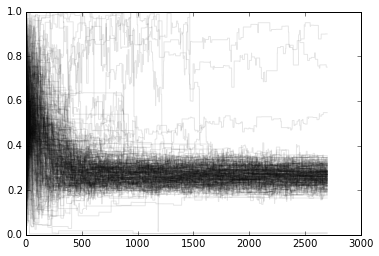

In [78]:
_ = plt.plot(fitter.sampler.chain[:, :, 5].T, 'k-', alpha=0.1)
#plt.ylim((-21, 0))
fitter.make_emcee_samples(1000)
#fitter.samples['Period'] = 10**fitter.samples['Period']
#fitter.samples['$K_1$'] = 10**fitter.samples['$K_1$']
#fitter.samples['e'] = 10**fitter.samples['e']

[  2.86707721e+00   7.72073536e+01  -4.96367422e+00   3.30213657e+02
  -5.41847790e-02   2.63157176e-01   0.00000000e+00]
[736.33799116039802, 77.207353607995117, 1.0872409082965053e-05, 330.2136572688031, 0.88270425695409271, 0.26315717585645493, 0.0]


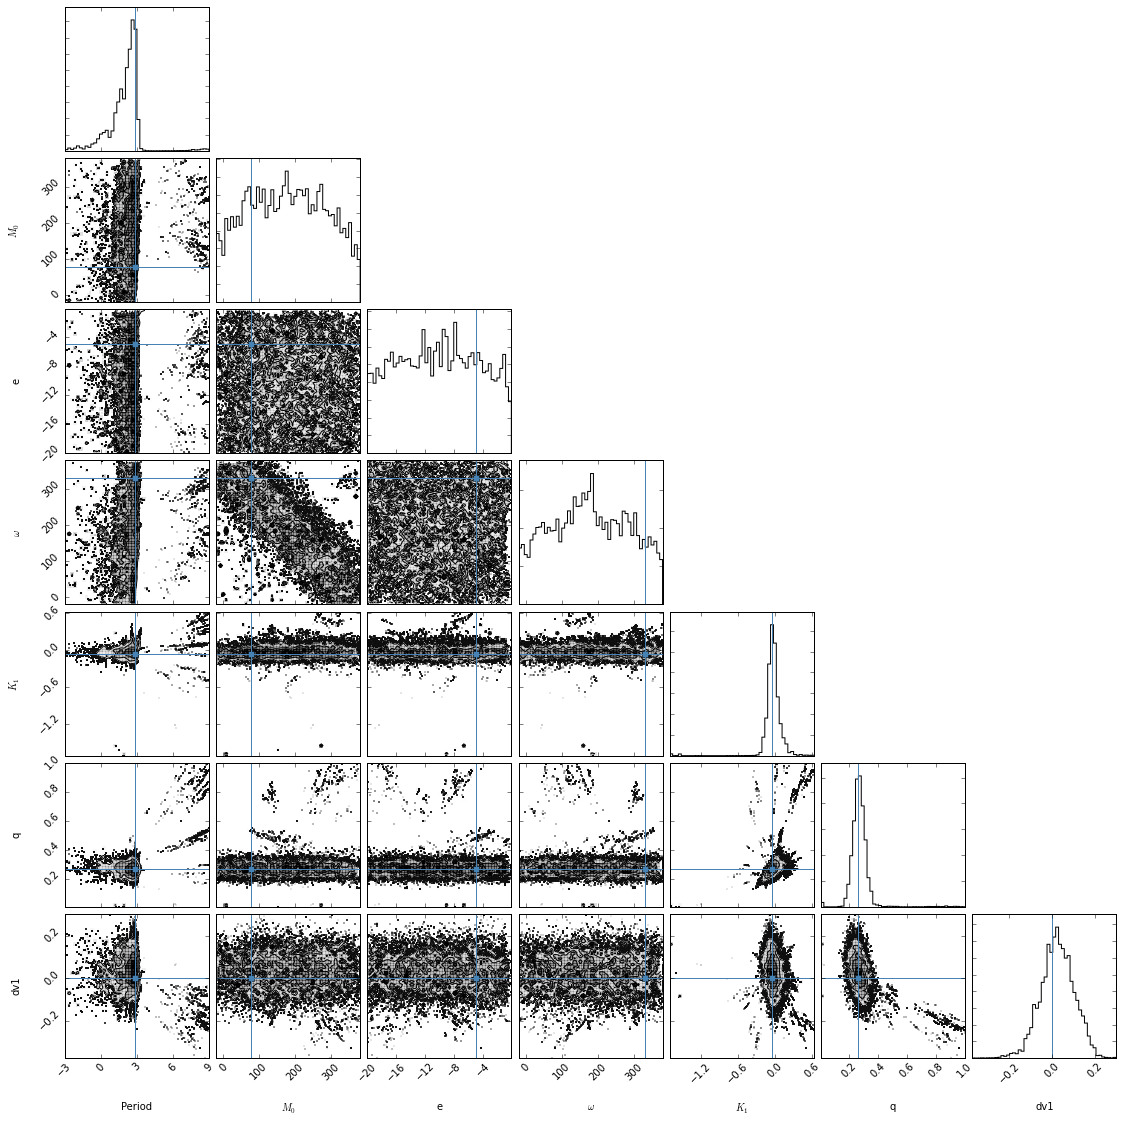

In [79]:
transformed_true_pars = np.array(true_pars).copy()
transformed_true_pars[0] = np.log10(transformed_true_pars[0])
transformed_true_pars[2] = np.log10(transformed_true_pars[2])
transformed_true_pars[4] = np.log10(transformed_true_pars[4])
fitter.triangle(truths=transformed_true_pars)
print(transformed_true_pars)
print(true_pars)

In [80]:
fitter.samples.describe()

$K_1$          $M_0$       $\omega$         Period  \
count  510000.000000  510000.000000  510000.000000  510000.000000   
mean       -0.034056     176.692581     178.621347       1.980103   
std         0.162887     105.386181     105.843704       1.308688   
min        -1.710109     -19.823140     -19.919141      -2.975112   
25%        -0.082409      89.017401      92.535295       1.472135   
50%        -0.034384     176.224432     177.258236       2.185748   
75%         0.019409     263.167648     266.451867       2.729491   
max         0.628213     379.838793     379.978473       8.999983   

                 dv1              e         lnprob              q  
count  510000.000000  510000.000000  510000.000000  510000.000000  
mean        0.025413     -10.147591      -0.993570       0.272090  
std         0.078078       5.469666      20.566431       0.070385  
min        -0.374743     -19.997590    -177.047867       0.005119  
25%        -0.023934     -14.774813       0.761489       0.242230  
50%         0.025391     -10.101074       2.064422       0.267849  
75%         0.077578      -5.620786       2.961570       0.294234  
max         0.300659      -0.129808       4.136897       0.999503

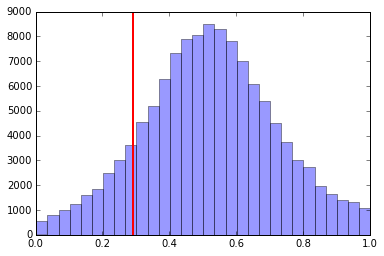

In [52]:
q = fitter.samples['q']
plt.hist(q, bins=30, alpha=0.4)
true_q = K1 / K2
plt.plot([true_q, true_q], plt.ylim(), 'r-', lw=2)

In [547]:
# Do we get the same thing with the multinest fitter?
fitter.fit(backend='multinest', basename='mn_unconstrained_test/idx{}-'.format(idx), overwrite=False)

[4863.763146094072, 140.7307361405249, 0.17777400094075141, 253.27718359251429, 0.45516469174785756, 0.29121719638431204, 0.0, 0.0]


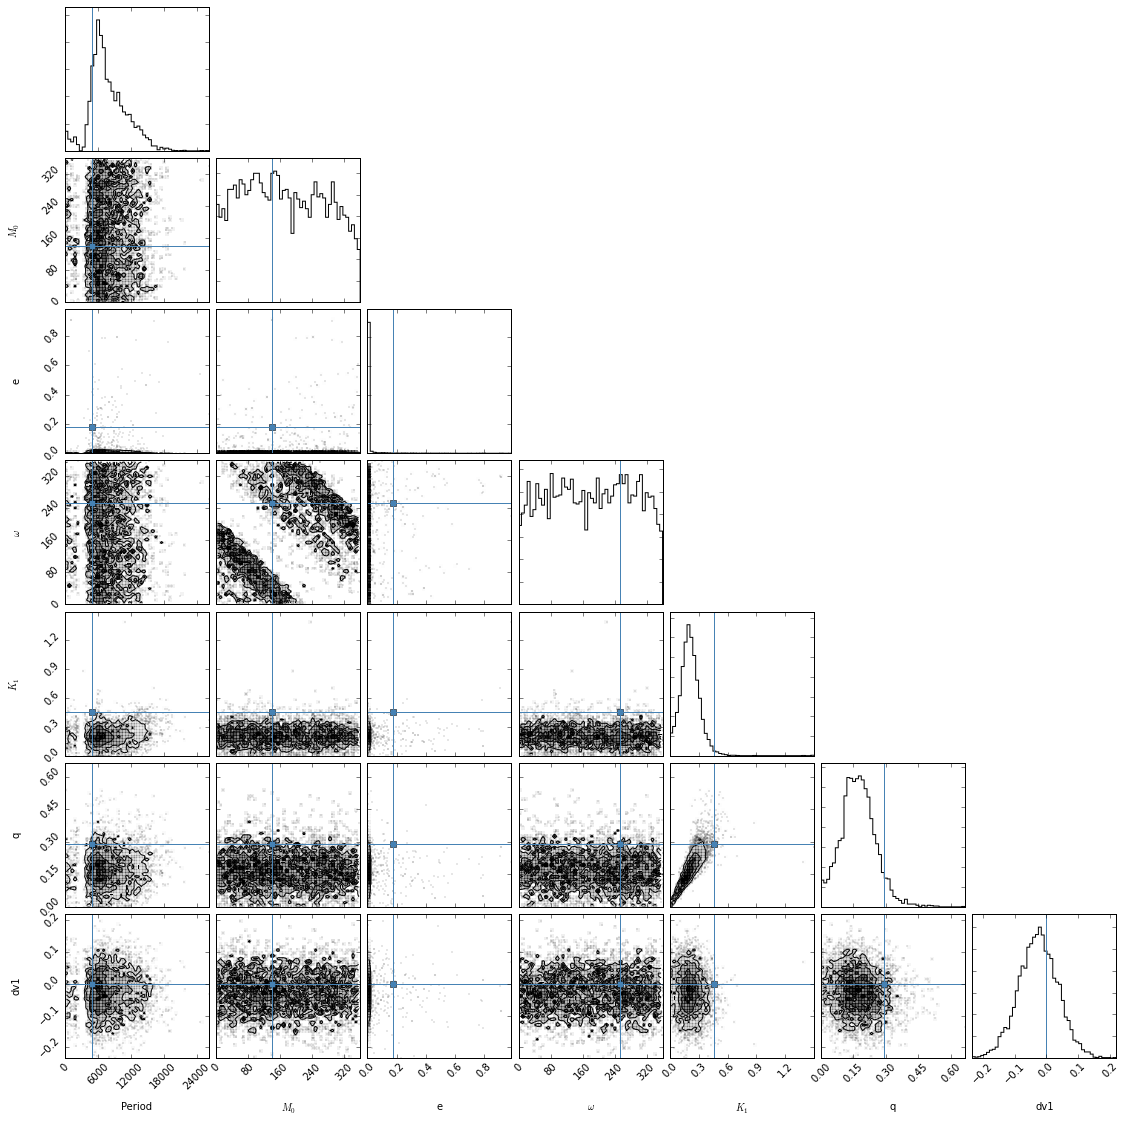

In [501]:
p = sample_parameters.ix[idx]
true_pars = [p['Period'], p['M0'], p['e'], p['little_omega'], K1, K1/K2, 0.0, 0.0]
print(true_pars)
fitter.triangle(truths=true_pars)

Percent of samples with q > true value = 6.292517%


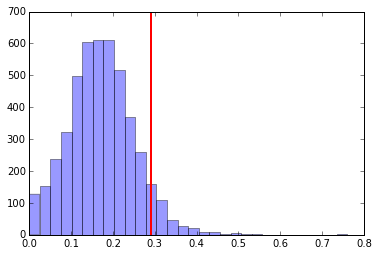

In [548]:
q = fitter.samples['q'] 
plt.hist(q, bins=30, alpha=0.4)
true_q = K1 / K2
plt.plot([true_q, true_q], plt.ylim(), 'r-', lw=2)
print 'Percent of samples with q > true value = {:%}'.format(sum(q>true_q)/float(len(q)))

In [361]:
# What if we start emcee with the wrong parameters?
# Let's use reasonable starting parameters that are the same for all orbits.
a = 400  # This is the peak of the semimajor axis distribution for A stars (from VAST survey)
M1 = sample_parameters.ix[idx, 'M_prim']  # Primary mass (we are assuming this is known...)
q = 0.37 # The average mass-ratio if gamma = 0.4
P = np.sqrt(a**3 / (M1*(1+q)))  # Convert from a to period
K1_guess = 0.5  # Make a guess at K1. It is probably low since these are (mostly) not known binaries.
initial_pars = [P, 180.0, 0.0, 180.0, K1_guess, K1_guess/q, 0.0, 0.0]
fitter.fit(backend='emcee', n_prod=2000, guess=False, initial_pars=initial_pars)

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
INFO:root:Done with burn-in iteration 1 / 200
INFO:root:Done with burn-in iteration 11 / 200
INFO:root:Done with burn-in iteration 21 / 200
INFO:root:Done with burn-in iteration 31 / 200
INFO:root:Done with burn-in iteration 41 / 200
INFO:root:Done with burn-in iteration 51 / 200
INFO:root:Done with burn-in iteration 61 / 200
INFO:root:Done with burn-in iteration 71 / 200
INFO:root:Done with burn-in iteration 81 / 200
INFO:root:Done with burn-in iteration 91 / 200
INFO:root:Done with burn-in iteration 101 / 200
INFO:root:Done with burn-in iteration 111 / 200
INFO:root:Done with 

Running burn-in
Running production

INFO:root:Done with production iteration 1 / 2000
INFO:root:Done with production iteration 11 / 2000
INFO:root:Done with production iteration 21 / 2000
INFO:root:Done with production iteration 31 / 2000
INFO:root:Done with production iteration 41 / 2000
INFO:root:Done with production iteration 51 / 2000
INFO:root:Done with production iteration 61 / 2000
INFO:root:Done with production iteration 71 / 2000
INFO:root:Done with production iteration 81 / 2000
INFO:root:Done with production iteration 91 / 2000
INFO:root:Done with production iteration 101 / 2000
INFO:root:Done with production iteration 111 / 2000
INFO:root:Done with production iteration 121 / 2000
INFO:root:Done with production iteration 131 / 2000
INFO:root:Done with production iteration 141 / 2000
INFO:root:Done with production iteration 151 / 2000
INFO:root:Done with production iteration 161 / 2000
INFO:root:Done with production iteration 171 / 2000
INFO:root:Done with production iteration 181 / 2000
INFO:root:Done with pro

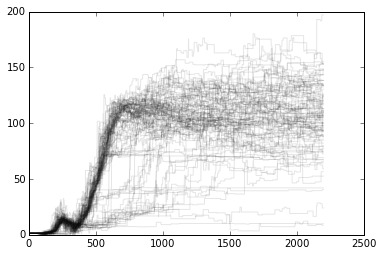

In [371]:
_ = plt.plot(fitter.sampler.chain[:, :, 5].T, 'k-', alpha=0.1)
#fitter.make_emcee_samples(750)

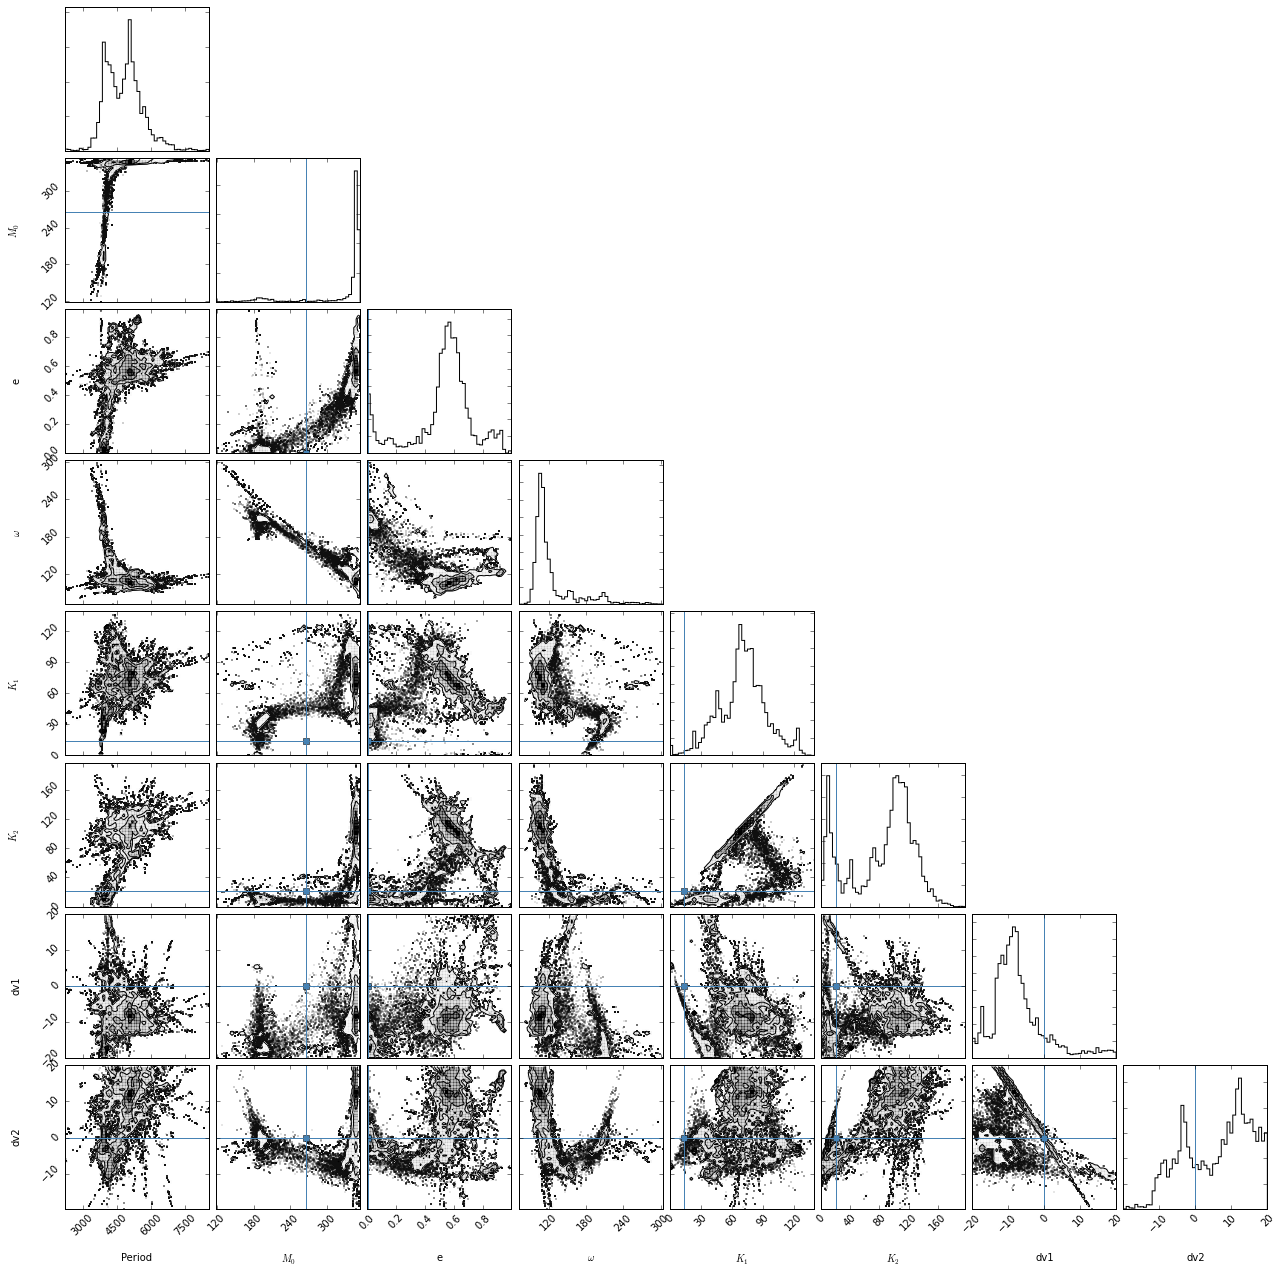

In [369]:
fitter.triangle(truths=true_pars)

## Lessons learned
If we have good initial guesses, emcee can gives you a solid answer pretty quickly. However, it gives the completely wrong answer if your initial guess is bad and sometimes even if it is good. In real life, I won't really be able to know how good the initial guess is, so that scares me. The multinest sampler takes a bit longer to converge since it effectively explores the entire parameter space; It gives the right answer for the mass-ratio, provided the primary star amplitude is big enough ($\gtrsim 1$ km/s, which is kind of unreasonable to ask...). For lower primary velocities, it still gets close-ish to the right mass-ratio but can be off by a couple sigma. 

The next question is: what if I give it information about the mass-ratio from the companion temperature? That (should) constrain the mass-ratio near what I want in the prior function and might force it to closer to the right answer? Let's try!


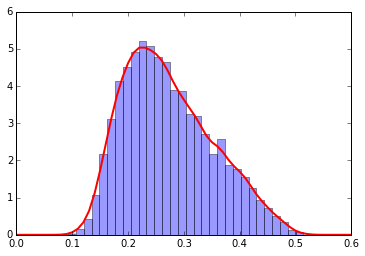

In [11]:
# Estimate P(q) from the information in sample_parameters
# First, sample values of q using the measured temperature and the primary star mass (+/- 1 Msun)
import Mamajek_Table
import scipy
MT = Mamajek_Table.MamajekTable()
teff2mass = MT.get_interpolator('Teff', 'Msun')
mass2teff = MT.get_interpolator('Msun', 'Teff')

M1_mean = sample_parameters.ix[idx, 'M_prim']
M1_std = 1.0
a, b = (1.5-M1_mean)/M1_std, np.inf
M1_vals = truncnorm.rvs(a=a, b=b, loc=M1_mean, scale=M1_std, size=10000)

T2_mean = mass2teff(sample_parameters.ix[idx, 'M_prim']*sample_parameters.ix[idx, 'q'])
T2_vals = np.random.normal(loc=T2_mean, scale=200, size=10000)
M2_vals = teff2mass(T2_vals)
q_vals = M2_vals/M1_vals

# Use kernel density estimation to get the PDF
kde = scipy.stats.gaussian_kde(q_vals)

_ = plt.hist(q_vals, bins=30, normed=True, alpha=0.4)
qplot = np.arange(*plt.xlim(), step=0.01)
_ = plt.plot(qplot, kde(qplot), 'r-', lw=2)

In [12]:
# Remake the fitter
#reload(Orbit)
fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, 
                                        primary_mass=sample_parameters.ix[idx, 'M_prim'], 
                                        q_prior=kde)


In [13]:
# Do we get the same thing with the multinest fitter?
fitter.fit(backend='multinest', basename='mn_unconstrained_qprior_test/idx{}-'.format(idx), overwrite=False)

[4863.763146094072, 140.7307361405249, 0.17777400094075141, 253.27718359251429, 0.45516469174785756, 0.29121719638431204, 0.0, 0.0]


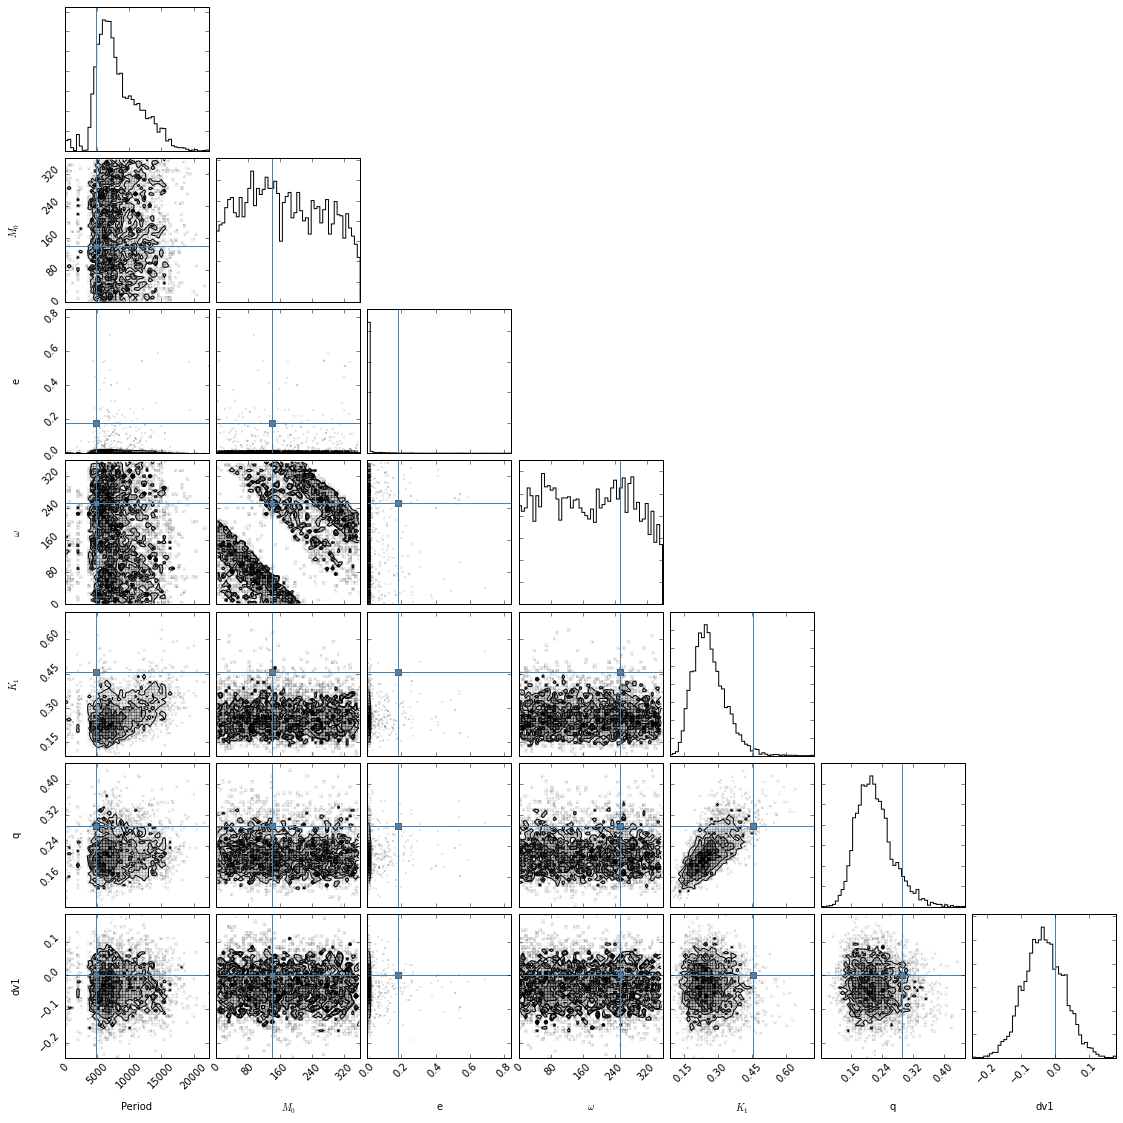

In [543]:
p = sample_parameters.ix[idx]
true_pars = [p['Period'], p['M0'], p['e'], p['little_omega'], K1, K1/K2, 0.0, 0.0]
print(true_pars)
fitter.triangle(truths=true_pars)

Percent of samples with q > true value = 8.604754%


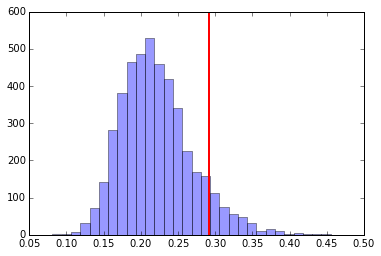

In [546]:
q = fitter.samples['q'] 
plt.hist(q, bins=30, alpha=0.4)
true_q = K1 / K2
plt.plot([true_q, true_q], plt.ylim(), 'r-', lw=2)
print 'Percent of samples with q > true value = {:%}'.format(sum(q>true_q)/float(len(q)))

## Well, that's a bit better...
It still really likes to have K1 and q off from their true values (they are correlated, obviously). Using the prior from the companion temperature measurement helps, but it just isn't strong enough to force the right answer. Let's take a look at some of the orbits.

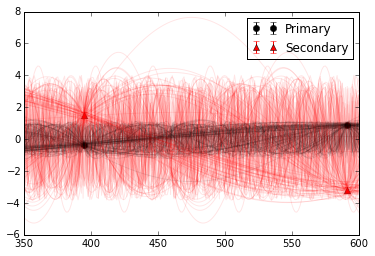

In [81]:
plt.errorbar(t_rv, rv1, yerr=rv1_err, fmt='ko', label='Primary')
plt.errorbar(t_rv, rv2, yerr=rv2_err, fmt='r^', label='Secondary')
xplot = {'t_rv': np.linspace(*plt.xlim(), num=200)}
rvs = fitter.predict(xplot, N=100)
for i in range(100):
    rv1_pred = rvs[i, 0, :]
    rv2_pred = rvs[i, 1, :]
    plt.plot(xplot['t_rv'], rv1_pred, 'k-', alpha=0.1)
    plt.plot(xplot['t_rv'], rv2_pred, 'r-', alpha=0.1)
leg = plt.legend(loc='best')
#plt.ylim((-2, 2))



That looks really reasonable, so there is probably nothing going wrong with the fit. It just likes the wrong values better because it is so unconstrained?

## Production
Alright, let's go ahead and do a bunch of really un-constrained fits to all 400 of my stars. I will save the results in the HDF5 file, along with the true parameters, so that I can compare later.

In [89]:
import Mamajek_Table
MT = Mamajek_Table.MamajekTable()
teff2mass = MT.get_interpolator('Teff', 'Msun')
mass2teff = MT.get_interpolator('Msun', 'Teff')

class OrbitPrior(object):
    def __init__(self, M1_vals, T2_vals, N_samp=10000, gamma=0.4):
        M1_vals = np.atleast_1d(M1_vals)
        T2_vals = np.atleast_1d(T2_vals)
        # Estimate the mass-ratio prior
        M1_std = np.maximum(0.5, 0.2*M1_vals)
        a, b = (1.5-M1_vals)/M1_std, np.ones_like(M1_vals)*np.inf
        M1_samples = np.array([truncnorm.rvs(a=a[i], b=b[i], loc=M1_vals[i], scale=M1_std[i], size=N_samp) for i in range(M1_vals.size)])
        T2_samples = np.array([np.random.normal(loc=T2_vals[i], scale=200, size=N_samp) for i in range(T2_vals.size)])
        M2_samples = teff2mass(T2_samples)
        q_samples = M2_samples/M1_samples
        
        self.empirical_q_prior = [scipy.stats.gaussian_kde(q_samples[i, :]) for i in range(q_samples.shape[0])]
        self.gamma = gamma
        
    def _evaluate_empirical_q_prior(self, q):
        q = np.atleast_1d(q)
        assert q.shape[0] == len(self.empirical_q_prior)
        return np.array([self.empirical_q_prior[i](q[i]) for i in range(q.shape[0])])
    
    def evaluate(self, q, a, e):
        empirical_prior = self._evaluate_empirical_q_prior(q)
        return (1-self.gamma)*q**(-self.gamma) * empirical_prior / (120*a*e*np.log(10)**2)
    
    def __call__(self, q, a, e):
        return self.evaluate(q, a, e)

In [ ]:

rv1_err = 0.1
rv2_err = 0.2

outfile = h5py.File('Simulation_Data.h5', 'a')
for i, row in sample_parameters.iterrows():
    print '\n\n{}'.format(i)
    # Make some observations of this binary system
    t_rv, rv1, rv2, t_im, rho, theta, K1, K2 = sample_orbit(row, N_rv=2, N_imag=0,
                                                    rv1_err=rv1_err, rv2_err=rv2_err)
        
    # Estimate the mass-ratio prior
    M1_mean = row['M_prim']
    T2_mean = mass2teff(row['M_prim']*row['q'])
    prior = OrbitPrior(M1_mean, T2_mean)
    q_prior = prior._evaluate_empirical_q_prior
    
    # Fit the orbit
    logging.debug('Creating Fitter...')
    fitter = Orbit.SpectroscopicOrbitFitter(rv_times=t_rv, rv1_measurements=rv1, rv1_err=rv1_err, 
                                        rv2_measurements=rv2, rv2_err=rv2_err, 
                                        primary_mass=M1_mean, 
                                        q_prior=q_prior)
    #true_pars = [row['Period'], row['M0'], row['e'], row['little_omega'], row['i'], K1, K1/K2, 0.0]
    logging.debug('Fitting...')
    #fitter.fit(backend='multinest', basename='mn_unconstrained_qprior_production/idx{}-'.format(i), overwrite=False)
    initial_pars = [[-3, 9], [0, 360], [-20, 0], [0, 360], [-3, 3], [0, 1], [-20, 20]]
    fitter.fit(backend='emcee', nwalkers=300, n_burn=1000, n_prod=1500, guess=False, initial_pars=initial_pars) 
        
    # Save the MCMC samples and the true parameters
    logging.debug('Saving MCMC samples')
    try:
        ds = outfile.create_dataset('unconstrained_emcee_qrior/ds{}'.format(i), data=fitter.samples, maxshape=(None, 8))
    except RuntimeError:
        ds = outfile['unconstrained_emcee_qrior/ds{}'.format(i)]
        ds.resize(fitter.samples.shape)
        ds[:] = fitter.samples
    for par in row.keys():
        ds.attrs[par] = row[par]
    ds.attrs['K1'] = K1
    ds.attrs['K2'] = K2
    ds.attrs['df_columns'] = list(fitter.samples.columns)
    outfile.flush()
    
outfile.close()

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 



0
K1 = 0.15326636322
K2 = 0.27222023556
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




1

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 3.30938099781
K2 = 5.03433215374
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




2

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 1.6438069505
K2 = 5.30972021455
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




3

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 17.4960919963
K2 = 50.6392037356
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




4

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
Orbit.py:486: RuntimeWarning: divide by zero encountered in log
  return ll if self.q_prior is None else ll + np.log(self.q_prior(pars[5]))
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iterati


K1 = 0.0309450089665
K2 = 0.724430289239
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




5

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 8.26869082896
K2 = 43.4785862682
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




6

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.0127877210759
K2 = 0.330003835075
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




7

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 1.41306931905
K2 = 2.40461326817
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




8

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.455164691748
K2 = 1.56297326325
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




9

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.882704256954
K2 = 3.35428533948
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




10

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.107683407194
K2 = 0.131753120349
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




11

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 3.02896900375
K2 = 8.79213667613
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




12

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.00715667639081
K2 = 0.0317452293204
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




13

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.218391849159
K2 = 1.94957477389
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




14

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.00574352504084
K2 = 0.460790352056
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




15

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 1.71655112964
K2 = 7.34165398015
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




16

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.0145604900293
K2 = 6.48309998653
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




17

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.147092184252
K2 = 1.15005464532
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




18

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.0930018030949
K2 = 0.291840284075
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




19

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 1.07306445843
K2 = 1.1368785941
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




20

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.130139953121
K2 = 5.20189397811
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




21

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.219099769989
K2 = 0.423876488654
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




22

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.319432430666
K2 = 1.01436341024
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




23

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.864645799506
K2 = 1.31637119485
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




24

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.0176221485284
K2 = 0.447472329845
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




25

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.0125383716085
K2 = 0.790701672165
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro




26

DEBUG:root:Creating Fitter...
DEBUG:root:Fitting...
INFO:root:Done with burn-in iteration 1 / 1000
INFO:root:Done with burn-in iteration 11 / 1000
INFO:root:Done with burn-in iteration 21 / 1000
INFO:root:Done with burn-in iteration 31 / 1000
INFO:root:Done with burn-in iteration 41 / 1000
INFO:root:Done with burn-in iteration 51 / 1000
INFO:root:Done with burn-in iteration 61 / 1000
INFO:root:Done with burn-in iteration 71 / 1000
INFO:root:Done with burn-in iteration 81 / 1000
INFO:root:Done with burn-in iteration 91 / 1000
INFO:root:Done with burn-in iteration 101 / 1000
INFO:root:Done with burn-in iteration 111 / 1000
INFO:root:Done with burn-in iteration 121 / 1000
INFO:root:Done with burn-in iteration 131 / 1000
INFO:root:Done with burn-in iteration 141 / 1000
INFO:root:Done with burn-in iteration 151 / 1000
INFO:root:Done with burn-in iteration 161 / 1000
INFO:root:Done with burn-in iteration 171 / 1000
INFO:root:Done with burn-in iteration 181 / 1000
INFO:root:Done with burn-in 


K1 = 0.448413954784
K2 = 2.07170460292
Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1500
INFO:root:Done with production iteration 11 / 1500
INFO:root:Done with production iteration 21 / 1500
INFO:root:Done with production iteration 31 / 1500
INFO:root:Done with production iteration 41 / 1500
INFO:root:Done with production iteration 51 / 1500
INFO:root:Done with production iteration 61 / 1500
INFO:root:Done with production iteration 71 / 1500
INFO:root:Done with production iteration 81 / 1500
INFO:root:Done with production iteration 91 / 1500
INFO:root:Done with production iteration 101 / 1500
INFO:root:Done with production iteration 111 / 1500
INFO:root:Done with production iteration 121 / 1500
INFO:root:Done with production iteration 131 / 1500
INFO:root:Done with production iteration 141 / 1500
INFO:root:Done with production iteration 151 / 1500
INFO:root:Done with production iteration 161 / 1500
INFO:root:Done with production iteration 171 / 1500
INFO:root:Done with production iteration 181 / 1500
INFO:root:Done with pro

In [5]:
with h5py.File('Simulation_data.h5', 'r') as f:
    ds = f['unconstrained/ds0']
    for a in ds.attrs:
        print a, ds.attrs[a]
    print ds.shape

M0 192.11366739
M_prim 3.53937679224
Period 328522.19406
a 8421.22671122
big_omega 264.011794009
e 0.112357597231
i 33.6247857022
little_omega 245.903057144
q 0.563023402373
K1 0.15326636322
K2 0.27222023556
df_columns ['$K_1$' '$M_0$' '$\\omega$' 'Period' 'dv1' 'e' 'lnprob' 'q']
(4628, 8)


In [126]:
import triangle
def triangle_plot(ds):
    """
    Make a triangle plot from a dataset created above
    """
    df = pd.DataFrame(data=ds.value, columns=ds.attrs['df_columns'])
    par_names = ['Period', '$M_0$', '$\\omega$', 'e', '$K_1$', 'q', 'dv1']
    samples = df[par_names].as_matrix()
    true_values = [ds.attrs['Period'], ds.attrs['M0'], ds.attrs['little_omega'], 
                   ds.attrs['e'], ds.attrs['K1'], ds.attrs['q'], 0.0]
    triangle.corner(samples, labels=par_names, truths=true_values)

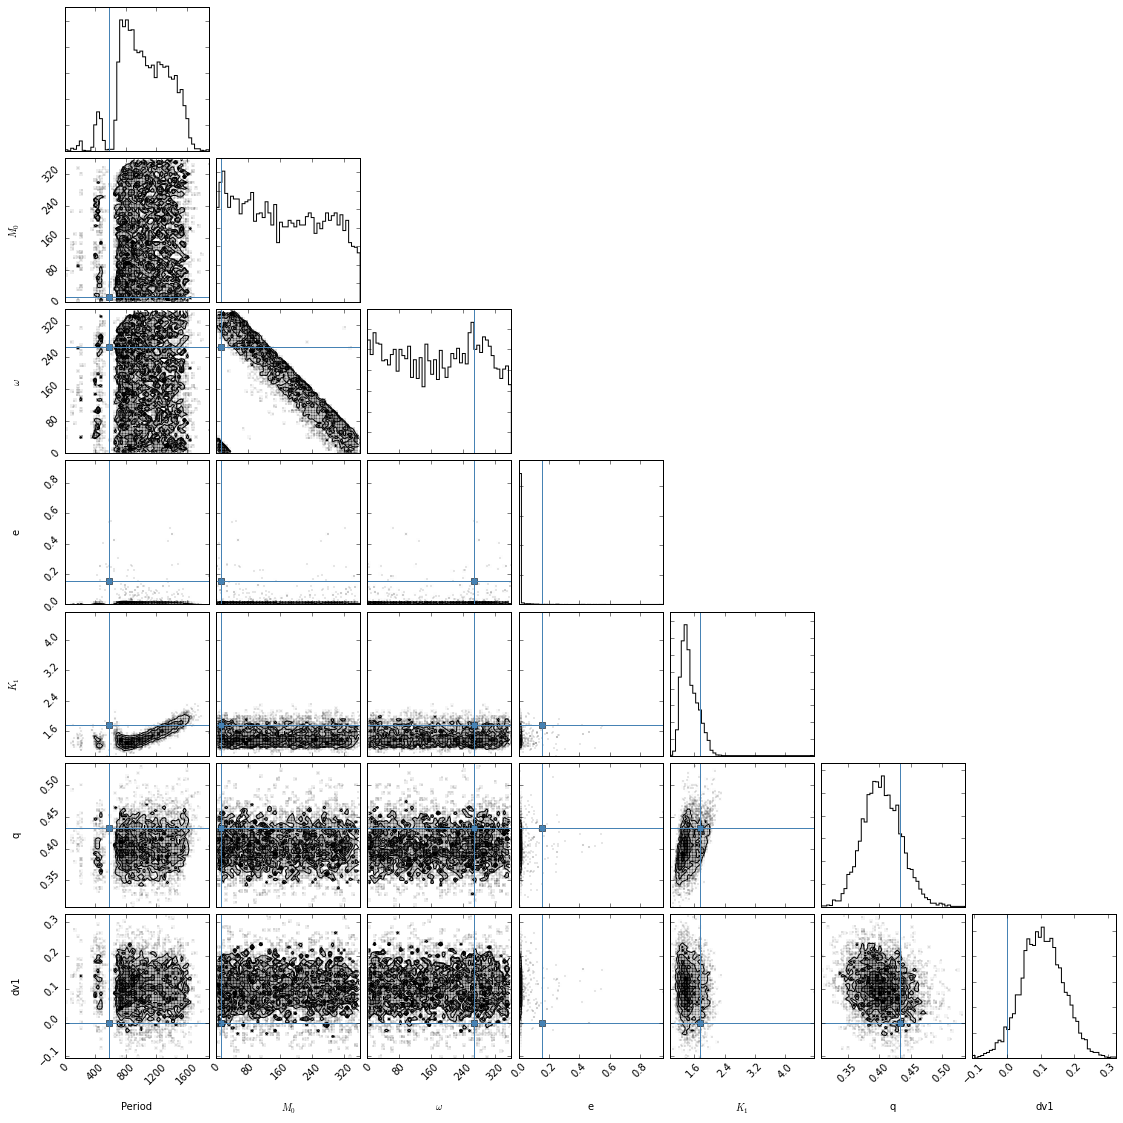

In [130]:
with h5py.File('Simulation_Data.h5', 'r') as f:
    triangle_plot(f['unconstrained2/ds140'])

# Distribution parameter estimation
Alright, the unconstrained orbit fits overall look alright (I just looked at a small sample of them, but $q$ is usually correct at least. The period is sometimes way off for some reason, but I wouldn't expect to be able to say much about the period from this data so I don't really care. The eccentricity is completely coming from the prior. Speaking of which...

I need to include the priors $p(\omega_k | \alpha)$ in the money equation now. The priors I used are:

  - mass-ratio (q): $P(q|\gamma, T_{\rm eff}, M_1) = (1-\gamma)q^{-\gamma} P(q|T_{\rm eff}, M_1) $
    - $P(q|T_{\rm eff}, M_1) $ comes from the simulated companion temperature measurement, and is different for each system! I estimate it by sampling from the companion temperature and primary mass distributions, and converting to mass-ratio through Eric Mamajek's spectral type conversion tables. It roughly constrains the mass-ratio to within $0.1-0.2$.
  - Eccentricity (e): $P(e) = \frac{1}{e\ln{10^{20}}}$
    - This is a log-uniform distribution for $10^{-20} < e < 1$. The lower limit should really be $-\infty$, but numerically this is the same and it lets the log function do the right thing.
  - Period (P): $P(P) = \frac{1}{P\ln{10^6}}$ (log-uniform from 1 --> $10^6$ years. THIS IS A TERRIBLE PRIOR! IT SHOULD GO DOWN TO 1 DAY, NOT 1 YEAR! I am fixing that on Adam's computer now, but let's move on)
  - I don't actually fit the semimajor axis, but can convert to it from the period prior using Kepler's law $P^2 = \frac{a^3}{M_1(1+q)}$
  - It works out to: $P(a|M_1, q) = \frac{1}{6a\ln{10}}$ if $10^{-2}[M_1(1+q)]^{(1/3)} < a < 10^{4}[M_1(1+q)]^{(1/3)}$ and 0 otherwise.
  
  
Coding up the prior is a bit difficult. I want a callable that takes the 2d numpy arrays a, e, and q and returns a single value. 

In [77]:
# Put all the relevant samples in a numpy array. 
with h5py.File('Simulation_Data.h5', 'r') as f:
    # First, get the maximum size
    maxlen = 0
    for _, dataset in f['unconstrained2'].iteritems():
        if dataset.shape[0] > maxlen:
            maxlen = dataset.shape[0]
    
    # Make a big numpy array filled with NaNs of max shape
    data = np.ones((len(f['unconstrained2']), maxlen, 3)) * np.nan
    M_prim = np.ones(len(f['unconstrained2'])) * np.nan
    M_sec = np.ones(len(f['unconstrained2'])) * np.nan
    
    # Fill the numpy array where possible
    for ds_name, dataset in f['unconstrained2'].iteritems():
        i = int(ds_name[2:])
        length = dataset.shape[0]
        df = pd.DataFrame(data=dataset.value, columns=dataset.attrs['df_columns'])
        M1 = dataset.attrs['M_prim']
        df['a'] = df['Period']**(2./3.) * (M1*(1+df['q']))**(1./3.)
        data[i, :length, :] = df[['q', 'a', 'e']]
        M_prim[i] = M1
        M_sec[i] = M1 * dataset.attrs['q']
        
        

In [78]:
import Mamajek_Table
MT = Mamajek_Table.MamajekTable()
teff2mass = MT.get_interpolator('Teff', 'Msun')
mass2teff = MT.get_interpolator('Msun', 'Teff')
T_sec = mass2teff(M_sec)

In [79]:
prior = OrbitPrior(M_prim, T_sec)

In [81]:
reload(Distributions)
dist_fitter = Distributions.DistributionFitter(data, prior)
#dist_fitter.guess_fit_parameters()

In [82]:
dist_fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, -1838.6720383684449]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -1838.6720363712361]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -1838.672038610478]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -1838.6720378253649]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -1838.6720450602811]
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999999234921194, 5.0000000765078809, 4.9999999235074206, 0.50000000763548647, -1838.6720510119121]
INFO:root:[0.50000000234921194, 5.0000000765078809, 4.9999999235074206, 0.50000000763548647, -1838.6720490147036]
INFO:root:[0.49999999234921194, 5.0000000865078809, 4.9999999235074206, 0.50000000763548647, -1838.6720512539453]
INFO:root:[0.49999999234921194, 5.0000000765078809, 4.9999999335074206, 0.50000000763548647, -183

array([ 0.31220121,  6.48360038,  2.3320019 ,  0.93475777])

In [83]:
dist_fitter.fit(backend='emcee', nwalkers=20, n_burn=1, n_prod=1000, guess=False, 
                initial_pars=[ 0.31220121,  6.48360038,  2.3320019 ,  0.93475777])

INFO:root:Done with burn-in iteration 1 / 1


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1000
INFO:root:Done with production iteration 11 / 1000
INFO:root:Done with production iteration 21 / 1000
INFO:root:Done with production iteration 31 / 1000
INFO:root:Done with production iteration 41 / 1000
INFO:root:Done with production iteration 51 / 1000
INFO:root:Done with production iteration 61 / 1000
INFO:root:Done with production iteration 71 / 1000
INFO:root:Done with production iteration 81 / 1000
INFO:root:Done with production iteration 91 / 1000
INFO:root:Done with production iteration 101 / 1000
INFO:root:Done with production iteration 111 / 1000
INFO:root:Done with production iteration 121 / 1000
INFO:root:Done with production iteration 131 / 1000
INFO:root:Done with production iteration 141 / 1000
INFO:root:Done with production iteration 151 / 1000
INFO:root:Done with production iteration 161 / 1000
INFO:root:Done with production iteration 171 / 1000
INFO:root:Done with production iteration 181 / 1000
INFO:root:Done with pro

AttributeError: 'DistributionFitter' object has no attribute 'n_params'

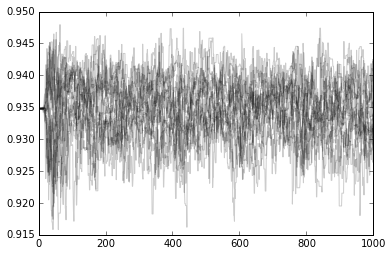

In [89]:
dist_fitter.n_params = 4
_ = plt.plot(dist_fitter.sampler.chain[:, :, 3].T, 'k-', alpha=0.2)
dist_fitter.make_emcee_samples(100)

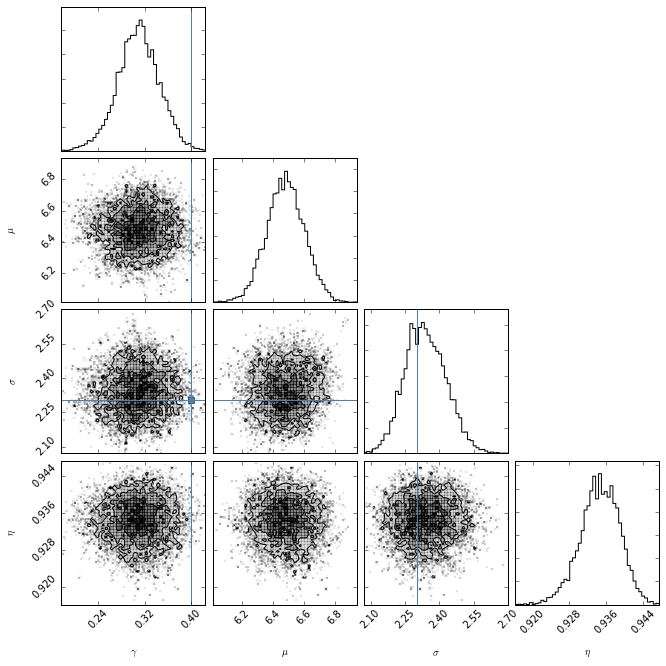

In [90]:
dist_fitter.triangle(truths=[0.4, np.log(200), np.log(10), 0.7])

# Wrong answer!
This gets the wrong answer for mass-ratio, and is much too precise for the period and eccentricity stuff. Oddly, it nails the separation distribution width. I think this may be related to the empirical mass-ratio prior for the really low-mass stuff. The spectral type relations only go down to M9 or so, and return nonsense after that. What if I limit my detections to q > 0.1 (just use a hard limit). I will need to use the Q variable now, which means the integral in Equation 11 matters. Hopefully this works better...

In [99]:
# Put all the relevant samples in a numpy array, censoring to "not detect" anything with q < 0.1. 
with h5py.File('Simulation_Data.h5', 'r') as f:
    # First, get the maximum size
    maxlen = 0
    n_datasets = 0
    for _, dataset in f['unconstrained2'].iteritems():
        if dataset.attrs['q'] > 0.1:
            n_datasets += 1
            
            if dataset.shape[0] > maxlen:
                maxlen = dataset.shape[0]
    
    # Make a big numpy array filled with NaNs of max shape
    censored_data = np.ones((n_datasets, maxlen, 3)) * np.nan
    censored_M_prim = np.ones(n_datasets) * np.nan
    censored_M_sec = np.ones(n_datasets) * np.nan
    
    # Fill the numpy array where possible
    i = 0
    for ds_name, dataset in f['unconstrained2'].iteritems():
        if dataset.attrs['q'] > 0.1:
            length = dataset.shape[0]
            df = pd.DataFrame(data=dataset.value, columns=dataset.attrs['df_columns'])
            M1 = dataset.attrs['M_prim']
            df['a'] = df['Period']**(2./3.) * (M1*(1+df['q']))**(1./3.)
            censored_data[i, :length, :] = df[['q', 'a', 'e']]
            censored_M_prim[i] = M1
            censored_M_sec[i] = M1 * dataset.attrs['q']
            i += 1

In [131]:
censored_T_sec = mass2teff(censored_M_sec)
prior = OrbitPrior(censored_M_prim, censored_T_sec)
q = censored_data[:, :, 0]
a = censored_data[:, :, 1]
e = censored_data[:, :, 2]
empirical_prior = prior._evaluate_empirical_q_prior(q)
prior_val = empirical_prior * (1-0.4)*q**(-gamma)
#prior_val = prior(q, a, e)

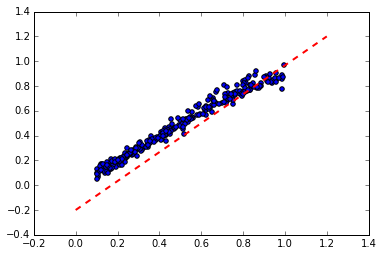

In [153]:
# Make a histogram of the median q values
q_median = np.nanmean(q, axis=1)
_ = plt.scatter(censored_M_sec/censored_M_prim, q_median)
_ = plt.plot(plt.xlim(), plt.ylim(), 'r--', lw=2)
#print np.mean(q, axis=1)

In [132]:
# Make the completeness function. The simple thing I have is analytical.
completeness = lambda q, a, e: np.greater_equal(q, 0.1).astype(np.int)
integral = lambda gamma, mu, sigma, eta: 1.0 - 10**(gamma-1.0)

In [139]:
reload(Distributions)
censored_dist_fitter = Distributions.DistributionFitter(censored_data, 
                                                        prior_fcn=None, 
                                                        completeness_fcn=completeness,
                                                        integral_fcn=integral)
censored_dist_fitter.prior = 1.0

In [140]:
# Estimate the best parameters using normal optimization
guess_pars = censored_dist_fitter.guess_fit_parameters()
print guess_pars

INFO:root:[0.5, 5.0, 5.0, 0.5, 85.898568080692812]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, 85.898571251134328]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, 85.898568080692812]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, 85.898568080692812]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, 85.898568080692812]
INFO:root:[0.0, 5.0, 5.0, 0.5, 144.7400691363963]
INFO:root:[1e-08, 5.0, 5.0, 0.5, 18.019316965434633]
INFO:root:[0.0, 5.0000000099999999, 5.0, 0.5, 144.7400691363963]
INFO:root:[0.0, 5.0, 5.0000000099999999, 0.5, 144.7400691363963]
INFO:root:[0.0, 5.0, 5.0, 0.50000001000000005, 144.7400691363963]
INFO:root:[0.24217151496734624, 5.0, 5.0, 0.5, 33.697637370811634]
INFO:root:[0.24217152496734623, 5.0, 5.0, 0.5, 33.697638529746541]
INFO:root:[0.24217151496734624, 5.0000000099999999, 5.0, 0.5, 33.697637370811634]
INFO:root:[0.24217151496734624, 5.0, 5.0000000099999999, 0.5, 33.697637370811634]
INFO:root:[0.24217151496734624, 5.0, 5.0, 0.50000001000000005, 33.697637370811634]
INF

[  5.13957185e-07   5.00000000e+00   5.00000000e+00   5.00000000e-01]


In [138]:
censored_dist_fitter._lnlike((0.1, 5.7, 2.3, 0.7))

-232.34384248938559

In [122]:
# Estimate the same using MCMC
guess_pars = (0.4, 5.7, 2.3, 0.7)
dist_fitter.fit(backend='emcee', nwalkers=20, n_burn=1, n_prod=1000, guess=False, 
                initial_pars=guess_pars)

INFO:root:Done with burn-in iteration 1 / 1


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1000
INFO:root:Done with production iteration 11 / 1000
INFO:root:Done with production iteration 21 / 1000
INFO:root:Done with production iteration 31 / 1000
INFO:root:Done with production iteration 41 / 1000
INFO:root:Done with production iteration 51 / 1000
INFO:root:Done with production iteration 61 / 1000
INFO:root:Done with production iteration 71 / 1000
INFO:root:Done with production iteration 81 / 1000
INFO:root:Done with production iteration 91 / 1000
INFO:root:Done with production iteration 101 / 1000
INFO:root:Done with production iteration 111 / 1000
INFO:root:Done with production iteration 121 / 1000
INFO:root:Done with production iteration 131 / 1000
INFO:root:Done with production iteration 141 / 1000
INFO:root:Done with production iteration 151 / 1000
INFO:root:Done with production iteration 161 / 1000
INFO:root:Done with production iteration 171 / 1000
INFO:root:Done with production iteration 181 / 1000
INFO:root:Done with pro

In [ ]:
dist_fitter

In [97]:
# Integration with scipy...
from scipy.integrate import tplquad
from functools import partial

# Define the integrand as a function of everything
def full_integrand(lna, e, q, gamma, mu, sigma, eta, Q_fcn):
    Gamma_q = (1-gamma)*q**(-gamma)
    Gamma_e = (1 - eta) * e ** (-eta)
    Gamma_a = 1. / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (lna - mu) ** 2 / sigma ** 2)
    return Gamma_q*Gamma_e*Gamma_a*Q_fcn(q, np.exp(lna), e)

# Completeness function
def Q_fcn(q, a, e):
    return 1 if q > 0.1 else 0.0

    
tplquad(full_integrand, 0, 1, lambda x: 0, lambda x: 1, lambda x,y: -3, lambda x,y: 20, args=(0.4, 5.7, 2.3, 0.7, Q_fcn))

(0.7487532514065993, 1.4121608882255998e-08)

In [98]:
%timeit tplquad(full_integrand, 0, 1, lambda x: 0, lambda x: 1, lambda x,y: -3, lambda x,y: 20, args=(0.4, 5.7, 2.3, 0.7, Q_fcn))

1 loops, best of 3: 56.4 s per loop


In [44]:
dist_fitter.prior

array([[  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       ..., 
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan]])

In [49]:
empirical = prior(dist_fitter.q, dist_fitter.a, dist_fitter.e)

In [70]:
full_prior = (1-prior.gamma)*dist_fitter.q**(-prior.gamma) * empirical / (120*dist_fitter.a*dist_fitter.e*np.log(10)**2)

In [73]:
dist_fitter.prior = full_prior/empirical
dist_fitter.guess_fit_parameters()

INFO:root:[0.5, 5.0, 5.0, 0.5, -2227.4640749364144]
INFO:root:[0.50000001000000005, 5.0, 5.0, 0.5, -2227.4640731196773]
INFO:root:[0.5, 5.0000000099999999, 5.0, 0.5, -2227.4640751800985]
INFO:root:[0.5, 5.0, 5.0000000099999999, 0.5, -2227.4640743898481]
INFO:root:[0.5, 5.0, 5.0, 0.50000001000000005, -2227.4640796559052]
INFO:root:[0.0, 10.0, 0.001, 0.999, inf]
INFO:root:[1e-08, 10.0, 0.001, 0.999, inf]
INFO:root:[0.0, 10.000000010000001, 0.001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.00100001, 0.999, inf]
INFO:root:[0.0, 10.0, 0.001, 0.99900001000000005, inf]
INFO:root:[0.49999999332027983, 5.0000000667972015, 4.9999999332161575, 0.50000000666636069, -2227.4640845740464]
INFO:root:[0.50000000332027983, 5.0000000667972015, 4.9999999332161575, 0.50000000666636069, -2227.4640827573094]
INFO:root:[0.49999999332027983, 5.0000000767972015, 4.9999999332161575, 0.50000000666636069, -2227.4640848177305]
INFO:root:[0.49999999332027983, 5.0000000667972015, 4.9999999432161575, 0.50000000666636069, -22

array([ 0.34952282,  6.49957167,  2.31117288,  0.92625537])

In [76]:
dist_fitter.fit(backend='emcee', nwalkers=20, n_burn=1, n_prod=1000, guess=False, initial_pars=[ 0.34952282,  6.49957167,  2.31117288,  0.92625537])

INFO:root:Done with burn-in iteration 1 / 1


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 1000
INFO:root:Done with production iteration 11 / 1000
INFO:root:Done with production iteration 21 / 1000



emcee: Exception while calling your likelihood function:

Traceback (most recent call last):
  File "/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py", line 515, in _lnprob
    return lp + self._lnlike(pars) if np.isfinite(lp) else -np.inf



  params: [ 0.3476261   6.49699939  2.31307702  0.92243348]
  args: []
  kwargs: {}
  exception:


  File "Distributions.py", line 45, in _lnlike
    Gamma_a = 1. / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (np.log(self.a) - mu) ** 2 / sigma ** 2)
KeyboardInterrupt


KeyboardInterrupt: 

In [67]:
T_sec

array([  8562.82190074,   8823.54522046,   6148.19663548,   5831.5121513 ,
         2988.3513554 ,   5654.45557133,   2765.49716096,   6462.04442203,
         4170.24724128,   3800.49003635,  15841.38821781,   4789.2249389 ,
         4558.31778942,   3165.41466788,   2450.        ,   4135.49177289,
         2450.        ,   3504.7019496 ,   5513.63010745,  10023.70449368,
         2705.21319463,   7124.86394268,   4889.4287194 ,   9906.61673495,
         3331.27012094,   2450.        ,   4108.55649859,   7757.01115994,
         2873.85480061,  12343.29877578,   3392.76933169,   3376.81285228,
         2450.        ,   4860.11343675,   3387.30264177,   8628.39727437,
         2450.        ,   2444.67524139,   2450.        ,   2629.57708352,
         8455.45423091,   3382.55101894,   3386.80759027,   7148.26004673,
        12309.49161102,  13632.0280876 ,   6072.09553786,   8746.69935025,
         2450.        ,   2450.        ,   5393.08620216,   4443.36478032,
        15328.92927212,  

In [23]:
q = data[:, :, 0]
a = data[:, :, 1]
e = data[:, :, 2]
# This will take about 20 minutes to calculate. Good thing I am only doing it once!
empirical_prior = prior(q, a, e)

In [25]:
prior.gamma = 0.4
full_prior = (1-prior.gamma)*q**(-prior.gamma) * empirical_prior / (120*a*e*np.log(10)**2)

In [27]:
print empirical_prior

[[  1.16382917e-001   1.31857163e+000   8.15874145e-001 ...,
                nan               nan               nan]
 [  3.97140951e-001   2.78918747e+000   1.48248655e+000 ...,
                nan               nan               nan]
 [  6.13660038e+000   6.12824114e+000   6.17582903e+000 ...,
                nan               nan               nan]
 ..., 
 [  1.21512557e-001   2.25802155e-003   2.14203833e+000 ...,
                nan               nan               nan]
 [  2.76895649e+000   1.44407408e+000   2.07112231e-106 ...,
                nan               nan               nan]
 [  5.28348646e-003   2.29148633e+000   2.37872081e+000 ...,
                nan               nan               nan]]


In [28]:
print q

[[ 0.99214882  0.71015515  0.77384698 ...,         nan         nan
          nan]
 [ 0.96950035  0.67135687  0.78706802 ...,         nan         nan
          nan]
 [ 0.29752291  0.27812317  0.29477937 ...,         nan         nan
          nan]
 ..., 
 [ 0.3172478   0.38147103  0.21912409 ...,         nan         nan
          nan]
 [ 0.0859926   0.02027025  0.32454023 ...,         nan         nan
          nan]
 [ 0.46933038  0.77586004  0.82191929 ...,         nan         nan
          nan]]


In [30]:
print full_prior

[[  3.26477729e+001   2.05161315e+008   8.25776180e+005 ...,
                nan               nan               nan]
 [  1.52685833e+007   3.63772691e+004   2.20992454e+008 ...,
                nan               nan               nan]
 [  3.71201915e+012   1.95571348e+006   5.36603910e-001 ...,
                nan               nan               nan]
 ..., 
 [  4.50369773e+011   2.16710200e+001   3.77532942e+002 ...,
                nan               nan               nan]
 [  3.22005328e+008   4.64917113e+010   1.86587939e-106 ...,
                nan               nan               nan]
 [  1.27218631e+002   3.99293429e+000   5.05319369e+002 ...,
                nan               nan               nan]]


In [38]:
gamma, mu, sigma, eta = 0.4, np.log(200), np.log(10), 0.7
Gamma_q = (1 - gamma) * q ** (-gamma)
Gamma_e = (1 - eta) * e ** (-eta)
Gamma_a = 1. / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (np.log(a) - mu) ** 2 / sigma ** 2)

Gamma = Gamma_q * Gamma_e * Gamma_a / full_prior
np.log(np.nanmean(Gamma, axis=1)).sum()

2398.108186514376

In [ ]:
np.nanm